In [ ]:
# import plotly.graph_objs as go
# import plotly.io as pio
# import ipywidgets as widgets
# from IPython.display import display
# import numpy as np
# import PIL.Image as Image
# import requests
# from io import BytesIO

# # Load a sample image (replace this with the path to your image)
# url = "https://via.placeholder.com/600x400"
# response = requests.get(url)
# img = Image.open(BytesIO(response.content))

# # Convert the image to a NumPy array
# img_np = np.array(img)
# # Create the figure with an image trace
# fig = go.FigureWidget(
#     data=[go.Image(z=img_np)],
#     layout=go.Layout(
#         title='Click on the image to see the coordinates',
#         xaxis=dict(showgrid=False, visible=False),
#         yaxis=dict(showgrid=False, visible=False, scaleanchor='x')
#     )
# )

# # Create an output widget to display the coordinates
# output = widgets.Output()

# # Click event handler
# def display_coordinates(trace, points, selector):
#     with output:
#         output.clear_output()
#         for point in zip(points.xs, points.ys):
#             print(f'Clicked coordinates: (x={int(point[0])}, y={int(point[1])})')

# # Attach the click event handler to the image trace
# fig.data[0].on_click(display_coordinates)

# # Display the plot and output
# display(fig, output)

21.378979051249452


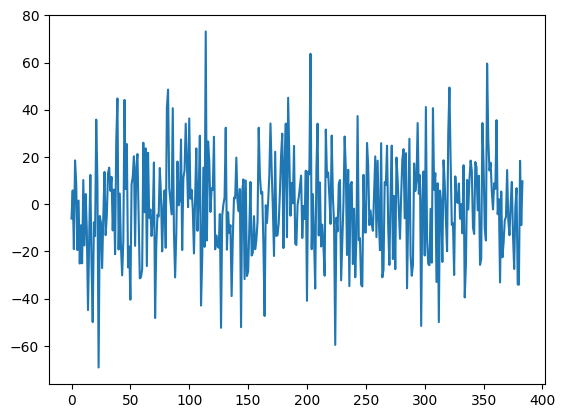

In [19]:
import matplotlib.pyplot as plt
plt.plot(Qx3)
print(Qx3.std())

In [37]:
# x1@x2, x1@x3, x2@x3
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(x1.reshape(1, -1), x2.reshape(1, -1)), cosine_similarity(x1.reshape(1, -1), x3.reshape(1, -1)), cosine_similarity(x2.reshape(1, -1), x3.reshape(1, -1))

(array([[-0.03894297]]), array([[-0.04155508]]), array([[0.03310255]]))

In [1]:
import numpy as np

# Dimensionality and matrix/vector generation
n = 384
K = np.random.normal(size=(n, n))
Q = np.random.normal(size=(n, n))
V = np.random.normal(size=(n, n))
x1 = np.random.normal(size=(n,))
x2 = np.random.normal(size=(n,))
x3 = np.random.normal(size=(n,))

# Compute transformed vectors
Kx1 = K @ x1
Kx2 = K @ x2
Kx3 = K @ x3
Qx1 = Q @ x1
Qx2 = Q @ x2
Qx3 = Q @ x3

# Compute attention scores and apply softmax
scores1 = np.array([np.dot(Qx1, Kx1), 0, 0])
scores2 = np.array([np.dot(Qx2, Kx1), np.dot(Qx2, Kx2), 0])
scores3 = np.array([np.dot(Qx3, Kx1), np.dot(Qx3, Kx2), np.dot(Qx3, Kx3)])

def stable_softmax(x):
    max_x = np.max(x)  # Find the maximum value to stabilize the computation
    exps = np.exp(x - max_x)  # Shift input by max value and compute exponentials
    return exps / np.sum(exps)

import scipy
import scipy.special
softmax1 = scipy.special.softmax(scores1)
softmax2 = scipy.special.softmax(scores2)
softmax3 = scipy.special.softmax(scores3)

# softmax1 = stable_softmax(scores1)
# softmax2 = stable_softmax(scores2)
# softmax3 = stable_softmax(scores3)

# Compute o1, o2, o3
o1 = V @ x1
o2 = V @ (softmax2[0] * x1 + softmax2[1] * x2)
o3 = V @ (softmax3[0] * x1 + softmax3[1] * x2 + softmax3[2] * x3)


# Dot products
dot_o1_o3 = np.dot(o1, o3)
dot_o2_o3 = np.dot(o2, o3)
dot_o1_o3, dot_o2_o3

(-20707.7211498385, 363.3376338929811)

In [13]:
softmax1, softmax2, softmax3, scores1, scores2, scores3

(array([1., 0., 0.]),
 array([0., 1., 0.]),
 array([1., 0., 0.]),
 array([6733.68808999,    0.        ,    0.        ]),
 array([5098.07404033, 8037.87152299,    0.        ]),
 array([12602.31443976,  8997.72666892,  5593.84833757]))

In [8]:
np.sum(np.exp(scores3))

/tmp/ipykernel_23478/3213587750.py:1: RuntimeWarning: overflow encountered in exp
  np.sum(np.exp(scores3))


inf

In [1]:
import sys
import os
%load_ext autoreload
%autoreload 2


sys.path.append('../')
os.chdir('../')

# Preparation

## Operation

In [2]:
import time
import math
import pickle
from contextlib import nullcontext

import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group


# from model import GPTConfig, GPT
from pe_info.model_nope import GPTConfig as GPTConfig_nope, GPT as GPT_nope
from main_utils import *

# -----------------------------------------------------------------------------
# default config values designed to train a gpt2 (124M) on OpenWebText
# I/O
out_dir = 'out'
resume_dir = None
resume_iter = False  # if True, resume from saved iter_num, otherwise resume from iter_num 0
eval_interval = 2000
log_interval = 1
eval_iters = 200
eval_only = False  # if True, script exits right after the first eval
always_save_checkpoint = True  # if True, always save a checkpoint after each eval
init_from = 'scratch'  # 'scratch' or 'resume' or 'gpt2*'
# wandb logging
wandb_entity = 'ssdd'
wandb_log = True  # disabled by default
wandb_project = 'owt'
wandb_run_name = 'gpt2'  # 'run' + str(time.time())
exp_name = 'default_exp_name'
# data
train_data_path = 'train_3digit_10000.txt'
gradient_accumulation_steps = 1  # used to simulate larger batch sizes
test_batch_size = 128
batch_size = 12  # if gradient_accumulation_steps > 1, this is the micro-batch size
block_size = 1024
val_data_path = 'val.bin'
multi_digit = False
num_digit = 5
binary = False
# using two data - data1 = text / data2 = addition
# use seperate text/add data for train/val (get_batch uses this to sample from two differernt datasets)
train_both = False
data_ratio = 0.2  # ratio of data_path2 compared with data_path1
train_data_path2 = 'train_addition.bin'  # only used when train_both = True
val_data_path2 = 'val_addition.bin'
# evaluation
eval_text = False  # if True get perplexity using eval_text_data_path
# directory to text data (.bin file) - ex. 'data/shakespeare_add_ar_mixed/val_text.bin'
eval_text_data_path = None
eval_addition = False  # if True compute test accuracy of "a+b="
start = "FILE:data/bal/test_10000.txt"
eval_addition_ar = False
start_ar = None
# use this to evaluate other operations (ex. train on operator '-' but evaluate on other_operator '+')
eval_other = False
start_other = None
other_operator = '+'
eval_addition_train = False
start_train = None
reverse_ab = False
reverse_c = False
zero_pad = False
algo_reason = False
add_space = False
# model
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2
bias = False  # do we use bias inside LayerNorm and Linear layers?
ckpt_path_name = 'ckpt.pt'
save_final = True
# adamw optimizer
learning_rate = 6e-4  # max learning rate
max_iters = 600000  # total number of training iterations
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
grad_clip = 1.0  # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
decay_lr = True  # whether to decay the learning rate
warmup_iters = 2000  # how many steps to warm up for
lr_decay_iters = 600000  # should be ~= max_iters per Chinchilla
min_lr = None  # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
# DDP settings
backend = 'nccl'  # 'nccl', 'gloo', etc.
# system
device = 'cuda' if torch.cuda.is_available() else 'cpu' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
# 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
try:
    dtype = 'bfloat16' if torch.cuda.is_bf16_supported() else 'float16'
except:
    dtype = 'float16'
compile = True  # use PyTorch 2.0 to compile the model to be faster
use_flash = True
data_type = 'text'
dataset = 'bal'
operator = '+'  # can be '+', '-', '*', 'sin', 'sqrt'
data_shuffle = True
# data_format = 'algo_reasoning' # 'plain' or 'reverse' or 'algo_reasoning'
data_format = 'plain'  # 'plain' or 'reverse' or 'algo_reasoning'

# can be 'all_ascii_chars' or 'numbers_only' or 'custom_input_data'
vocabulary = 'all_ascii_chars'
meta_path_specified = False  # use saved meta_file (False if data_type='text')
eps = 0
tokenizer = 'char'  # by default, use char level tokenizer. but for pretrained models, use openai tokenizer eg: 'gpt2'

simple = False
random_A = False
random_C = False

use_lora = False  # use lora (from minLoRA)
print_interval = 2  # if we're using gpt-2 model, I want to see it prompted on text

general_seed = 1337
# general_seed = 1227
resume_metric_from_best = True
use_pe = 'original'
use_residual = True
no_att_residual = False
no_mlp_residual = False
layerwise_pe = False
permute = False
not_causal = False

causal_training = True


config_keys = [k for k, v in globals().items() if not k.startswith(
    '_') and isinstance(v, (int, float, bool, str, type(None)))]
# exec(open('./pe_info/config2_pe/modp/jason_train_addition_bal.py').read()) # overrides from command line or config file
# overrides from command line or config file
exec(open('./pe_info/config2_pe/addition/reverse/jason_train_addition_bal.py').read())

config = {k: globals()[k] for k in config_keys}  # will be useful for logging
device = 'cuda' if torch.cuda.is_available() else 'cpu' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks


In [3]:
print(causal_training)
causal_training = False
eval_addition_train

True


True

In [4]:
# for later use in torch.autocast
device_type = 'cuda' if 'cuda' in device else 'cpu'
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32,
           'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(
    device_type=device_type, dtype=ptdtype)

# poor man's data loader
if data_type == 'binary':
    data_dir = os.path.join('data', dataset)
    train_data = np.memmap(os.path.join(
        data_dir, train_data_path), dtype=np.uint16, mode='r')
    val_data = np.memmap(os.path.join(
        data_dir, val_data_path), dtype=np.uint16, mode='r')
    if train_both:
        train_data2 = np.memmap(os.path.join(
            data_dir, train_data_path2), dtype=np.uint16, mode='r')
        val_data2 = np.memmap(os.path.join(
            data_dir, val_data_path2), dtype=np.uint16, mode='r')
    if eval_text:
        if eval_text_data_path is None:
            print(
                'eval_text_data_path is None!!! No binary file to evaluate perplexity on.')
        eval_text_data = np.memmap(
            eval_text_data_path, dtype=np.uint16, mode='r')
    # test_data_str = None # test_data for addition testing will be handled with "start"
    meta_path = None
else:
    # check for data_format
    if data_type == 'text':
        if ('reverse' in data_format and not reverse_c) or (reverse_c and 'reverse' not in data_format):
            raise ValueError(
                'reverse_c must be True for data_format == "reverse"')
        elif (data_format == 'algo_reasoning' and not algo_reason) or (algo_reason and data_format != 'algo_reasoning'):
            raise ValueError(
                'algo_reason must be True for data_format == "algo_reasoning"')
    meta_path_specified = False

    data_dir = os.path.join('data', dataset)
    train_data_path = os.path.join(data_dir, train_data_path)
    # val_data = os.path.join(data_dir, val_data_path)
    train_data_list = get_data_list(
        train_data_path, operator=operator)  # a list of (x, y, op)
    # get_data_list(val_data, operator='+')
    val_data_list = get_data_list(filename=None, operator=operator)
    train_data_str = generate_data_str(train_data_list, operator=operator, format=data_format, train=True,
                                       shuffle=data_shuffle, add_space=add_space, simple=simple, random_A=random_A, random_C=random_C)
    val_data_str = generate_data_str(val_data_list, operator=operator, format=data_format, train=True,
                                     shuffle=data_shuffle, add_space=add_space, simple=simple, random_A=random_A, random_C=random_C)
    meta, meta_path, data_encoder, data_decoder = create_meta_file(
        vocabulary=vocabulary, input_data_str=train_data_str, tokenizer=tokenizer)
    meta_vocab_size = meta['vocab_size']
    train_data = data_encoder(train_data_str)
    val_data = data_encoder(val_data_str)
    if eval_addition_train and start_train is None:
        # specify the start_train to be our train data file
        start_train = f"FILE:{train_data_path}"

    if train_both:
        # This is for the case where we use two different datasets for training
        # we sample from both with a specified ratio - data_ratio
        # TODO: let's leave this here for now.
        train_data2 = np.memmap(os.path.join(
            data_dir, train_data_path2), dtype=np.uint16, mode='r')
        val_data2 = np.memmap(os.path.join(
            data_dir, val_data_path2), dtype=np.uint16, mode='r')

    if eval_text:
        # eval_text_data = np.memmap(eval_text_data_path, dtype=np.uint16, mode='r')
        text_data_list = get_data_list(eval_text_data_path, operator='text')
        text_data_str = generate_data_str(
            text_data_list, operator='text', format=data_format, train=False, shuffle=False)
        eval_text_data = data_encoder(text_data_str)

Creating meta file for all reasonable characters...
all the unique characters: 
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~
vocab size: 96
data has 139,890 tokens
data has 14,295 tokens


In [5]:
from numpy import block


space_token = data_encoder(' ')[0]
switch_line_token = data_encoder('\n')[0]
equal_token = data_encoder('=')[0]
dollar_token = data_encoder('$')[0]
# non_causal_fix_length = 15
# non_causal_fix_length = 27
answer_length = 1
# def get_batch(split):
#         attn_mask = None
#         data = train_data if split == 'train' else val_data
#         if train_both:
#             data2 = train_data2 if split == 'train' else val_data2
#             batch_size2 = int(batch_size*data_ratio)
#             ix = torch.randint(len(data) - block_size, (batch_size-batch_size2,))
#             ix2 = torch.randint(len(data2) - block_size, (batch_size2,))
#         else:
#             if causal_training:
#                 ix = torch.randint(len(data) - block_size, (batch_size,))
#             else:
#                 split_points = np.where(data==(switch_line_token))[0]
#                 answer_split_points = np.where(data==(equal_token))[0]
#                 answer_length_list = split_points - answer_split_points - 1
#                 split_points = split_points + 1 # i should have had this
#                 split_points = np.hstack([np.array([0]), split_points.flatten()])

#                 sample_length_list = np.diff(split_points)
#                 start_points = split_points[:-1]

#                 randidx = np.random.permutation(len(start_points))[:batch_size]
#                 ix = start_points[randidx]
#                 sample_length_list = sample_length_list[randidx]
#                 answer_length_list = answer_length_list[randidx]

#         if causal_training:
#             x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
#             y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
#         else:
#             remove_dollar_count = 1 if dollar_token in data else 0
#             # cur_answer_length_list = np.random.randint(1+remove_dollar_count, answer_length_list+1) + 1
#             x = []
#             y = []
#             picked_i = []
#             picked_len = []
#             for i in range(len(ix)):
#                 for j in range(1+remove_dollar_count+1, answer_length_list[i]+2):
#                     x.append(data[ix[i]:ix[i]+sample_length_list[i]-j].astype(np.int64))
#                     y.append(data[ix[i]+sample_length_list[i]-j:ix[i]+1+sample_length_list[i]-j].astype(np.int64))
#                     picked_i.append(i)
#                     picked_len.append(j)
#                     if len(x) == batch_size:
#                         break

#                 if len(x) == batch_size:
#                     break
#             # x = [data[ix[i]:ix[i]+sample_length_list[i]-cur_answer_length_list[i]].astype(np.int64) for i in range(len(ix))]
#             x_len = [len(x[i]) for i in range(len(x))]
#             pad_to_length = max(x_len)
#             min_length = min(x_len)
#             # only do padding when the length is not equal
#             if pad_to_length > min_length:
#                 x = np.vstack([np.pad(x[i], (pad_to_length-len(x[i]), 0), mode='constant', constant_values=space_token) for i in range(len(x))])
#                 attn_mask = np.ones_like(x)
#                 # mask out the paddings
#                 attn_mask[x==space_token] = 0
#                 attn_mask = attn_mask[..., None]
#                 attn_mask = attn_mask @ attn_mask.transpose(0, 2, 1)
#                 attn_mask = attn_mask.astype(bool)
#                 if (attn_mask==1).all():
#                     attn_mask = None
#                 else:
#                     attn_mask = torch.from_numpy(attn_mask)
#             x = torch.from_numpy(x)
#             # predict the next digit
#             # y = torch.stack([torch.from_numpy((data[ix[i]+sample_length_list[i]-cur_answer_length_list[i]:ix[i]+1+sample_length_list[i]-cur_answer_length_list[i]]).astype(np.int64)) for i in range(len(ix))])
#             y = torch.from_numpy(np.array(y))
#         if train_both:
#             x2 = torch.stack([torch.from_numpy((data2[i:i+block_size]).astype(np.int64)) for i in ix2])
#             y2 = torch.stack([torch.from_numpy((data2[i+1:i+1+block_size]).astype(np.int64)) for i in ix2])
#             x = torch.cat([x,x2])
#             y = torch.cat([y,y2])

#         if device_type == 'cuda':
#             # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
#             x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
#             if attn_mask is not None:
#                 attn_mask = attn_mask.pin_memory().to(device, non_blocking=True)
#         else:
#             x, y = x.to(device), y.to(device)
#             if attn_mask is not None:
#                 attn_mask = attn_mask.to(device)

#         # attn_mask = None
#         return x, y, attn_mask

# split= "train"

# def get_batch(split, autoregressive_training=False):
#         attn_mask = None
#         w = None
#         data = train_data if split == 'train' else val_data
#         if train_both:
#             data2 = train_data2 if split == 'train' else val_data2
#             batch_size2 = int(batch_size*data_ratio)
#             ix = torch.randint(len(data) - block_size, (batch_size-batch_size2,))
#             ix2 = torch.randint(len(data2) - block_size, (batch_size2,))
#         else:
#             if causal_training:
#                 ix = torch.randint(len(data) - block_size, (batch_size,))
#             else:
#                 split_points = np.where(data==(switch_line_token))[0]
#                 answer_split_points = np.where(data==(equal_token))[0]
#                 answer_length_list = split_points - answer_split_points - 1
#                 split_points = split_points + 1 # i should have had this
#                 split_points = np.hstack([np.array([0]), split_points.flatten()])

#                 sample_length_list = np.diff(split_points)
#                 start_points = split_points[:-1]

#                 # valid_choices = np.where(start_points>block_size)[0]
#                 # start_points = start_points[valid_choices]
#                 # sample_length_list = sample_length_list[valid_choices]

#                 randidx = np.random.permutation(len(start_points))[:batch_size]
#                 ix = start_points[randidx]
#                 sample_length_list = sample_length_list[randidx]
#                 answer_length_list = answer_length_list[randidx]

#         if causal_training:
#             x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
#             y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
#         else:
#             # remove_dollar_count = 1 if dollar_token in data else 0
#             # if not autoregressive_training:
#             #     cur_answer_length_list = np.random.randint(1+remove_dollar_count, answer_length_list+1) + 1
#             # else:
#             #     cur_answer_length_list = answer_length_list + 1
#             # x = [data[ix[i]:ix[i]+sample_length_list[i]-cur_answer_length_list[i]].astype(np.int64) for i in range(len(ix))]
#             # x_len = [len(x[i]) for i in range(len(x))]
#             # pad_to_length = max(x_len)
#             # min_length = min(x_len)
#             # # only do padding when the length is not equal
#             # if pad_to_length > min_length:
#             #     x = np.vstack([np.pad(x[i], (pad_to_length-len(x[i]), 0), mode='constant', constant_values=space_token) for i in range(len(x))])
#             #     attn_mask = np.ones_like(x)
#             #     # mask out the paddings
#             #     attn_mask[x==space_token] = 0
#             #     attn_mask = attn_mask[..., None]
#             #     attn_mask = attn_mask @ attn_mask.transpose(0, 2, 1)
#             #     attn_mask = attn_mask.astype(bool)
#             #     if (attn_mask==1).all():
#             #         attn_mask = None
#             #     else:
#             #         attn_mask = torch.from_numpy(attn_mask)
#             # else:
#             #     x = np.vstack(x)
#             #     attn_mask = None

#             # x = torch.from_numpy(x)
#             # # predict the next digit
#             # if not autoregressive_training:
#             #     y = torch.stack([torch.from_numpy((data[ix[i]+sample_length_list[i]-cur_answer_length_list[i]:ix[i]+1+sample_length_list[i]-cur_answer_length_list[i]]).astype(np.int64)) for i in range(len(ix))])
#             # else:
#             #     y = [torch.from_numpy((data[ix[i]+sample_length_list[i]-cur_answer_length_list[i]:ix[i]-1+sample_length_list[i]]).astype(np.int64)) for i in range(len(ix))]
#             #     max_len_y = max([len(y[i]) for i in range(len(y))])
#             #     y = np.vstack([np.pad(y[i], (0, max_len_y-len(y[i])+pad_to_length-x_len[i]), mode='constant', constant_values=space_token) for i in range(len(y))])
#             #     y = torch.from_numpy(y)
#             #     w = torch.ones_like(y)
#             #     w[y==space_token] = 0
#             x = torch.stack([torch.from_numpy((data[i:i+block_size//4]).astype(np.int64)) for i in ix])
#             y = torch.stack([torch.from_numpy((data[i+block_size//4:i+5+block_size//4]).astype(np.int64)) for i in ix])
#             w = torch.ones_like(y)

#         if train_both:
#             x2 = torch.stack([torch.from_numpy((data2[i:i+block_size]).astype(np.int64)) for i in ix2])
#             y2 = torch.stack([torch.from_numpy((data2[i+1:i+1+block_size]).astype(np.int64)) for i in ix2])
#             x = torch.cat([x,x2])
#             y = torch.cat([y,y2])

#         if device_type == 'cuda':
#             # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
#             x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
#             if w is not None:
#                 w = w.pin_memory().to(device, non_blocking=True)
#             if attn_mask is not None:
#                 attn_mask = attn_mask.pin_memory().to(device, non_blocking=True)
#         else:
#             x, y = x.to(device), y.to(device)

#             if attn_mask is not None:
#                 attn_mask = attn_mask.to(device)

#         # attn_mask = None
#         return x, y, attn_mask, w


def get_batch(split, autoregressive_training=False, batch_size=batch_size):
    attn_mask = None
    w = None
    data = train_data if split == 'train' else val_data
    if train_both:
        data2 = train_data2 if split == 'train' else val_data2
        batch_size2 = int(batch_size*data_ratio)
        ix = torch.randint(len(data) - block_size, (batch_size-batch_size2,))
        ix2 = torch.randint(len(data2) - block_size, (batch_size2,))
    else:
        if causal_training:
            ix = torch.randint(len(data) - block_size, (batch_size,))
        else:
            split_points = np.where(data == (switch_line_token))[0]
            answer_split_points = np.where(data == (equal_token))[0]
            answer_length_list = split_points - answer_split_points - 1
            split_points = split_points + 1  # i should have had this
            split_points = np.hstack([np.array([0]), split_points.flatten()])

            sample_length_list = np.diff(split_points)
            start_points = split_points[:-1]

            randidx = np.random.permutation(len(start_points))[:batch_size]
            ix = start_points[randidx]
            sample_length_list = sample_length_list[randidx]
            answer_length_list = answer_length_list[randidx]

    if causal_training:
        x = torch.stack(
            [torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
        y = torch.stack(
            [torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    else:
        remove_dollar_count = 1 if dollar_token in data else 0
        if not autoregressive_training:
            cur_answer_length_list = np.random.randint(
                1+remove_dollar_count, answer_length_list+1) + 1
        else:
            cur_answer_length_list = answer_length_list + 1 + 4
        x = [data[ix[i]:ix[i]+sample_length_list[i]-cur_answer_length_list[i]
                  ].astype(np.int64) for i in range(len(ix))]
        x_len = [len(x[i]) for i in range(len(x))]
        pad_to_length = max(x_len)
        min_length = min(x_len)
        # only do padding when the length is not equal
        if pad_to_length > min_length:
            x = np.vstack([np.pad(x[i], (pad_to_length-len(x[i]), 0), mode='constant',
                          constant_values=space_token) for i in range(len(x))])
            attn_mask = np.ones_like(x)
            # mask out the paddings
            attn_mask[x == space_token] = 0
            attn_mask = attn_mask[..., None]
            attn_mask = attn_mask @ attn_mask.transpose(0, 2, 1)
            attn_mask = attn_mask.astype(bool)
            if (attn_mask == 1).all():
                attn_mask = None
            else:
                attn_mask = torch.from_numpy(attn_mask)
        else:
            x = np.vstack(x)
            attn_mask = None

        x = torch.from_numpy(x)
        # predict the next digit
        if not autoregressive_training:
            y = torch.stack([torch.from_numpy((data[ix[i]+sample_length_list[i]-cur_answer_length_list[i]:ix[i] +
                            1+sample_length_list[i]-cur_answer_length_list[i]]).astype(np.int64)) for i in range(len(ix))])
        else:
            y = [torch.from_numpy((data[ix[i]+sample_length_list[i]-cur_answer_length_list[i]:ix[i]-1+sample_length_list[i]]).astype(np.int64)) for i in range(len(ix))]
            max_len_y = max([len(y[i]) for i in range(len(y))])
            y = np.vstack([np.pad(y[i], (0, max_len_y-len(y[i])), mode='constant',
                          constant_values=space_token) for i in range(len(y))])
            y = torch.from_numpy(y)
            w = torch.ones_like(y)
            w[y == space_token] = 0

    if train_both:
        x2 = torch.stack(
            [torch.from_numpy((data2[i:i+block_size]).astype(np.int64)) for i in ix2])
        y2 = torch.stack(
            [torch.from_numpy((data2[i+1:i+1+block_size]).astype(np.int64)) for i in ix2])
        x = torch.cat([x, x2])
        y = torch.cat([y, y2])

    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(
            device, non_blocking=True)
        if autoregressive_training:
            w = w.pin_memory().to(device, non_blocking=True)
        if attn_mask is not None:
            attn_mask = attn_mask.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)

        if attn_mask is not None:
            attn_mask = attn_mask.to(device)

    # attn_mask = None
    return x, y, attn_mask, w

data has 1 tokens
data has 1 tokens
data has 1 tokens
data has 1 tokens


In [6]:
causal_training = False
x, y, z, w = get_batch('train', autoregressive_training=False)

print(x.shape, y.shape)
if z is not None:
    print(z.shape)

for i in range(min(10, len(x))):
    print(data_decoder(x[i].cpu().numpy()), data_decoder(y[i].cpu().numpy()))
    for xi in x[i].cpu().numpy():
        print(data_decoder(xi[..., None]), end=',')
    print()

torch.Size([256, 12]) torch.Size([256, 1])
torch.Size([256, 12, 12])
$455+846=103 1
$,4,5,5,+,8,4,6,=,1,0,3,
$999+922=129 1
$,9,9,9,+,9,2,2,=,1,2,9,
 $926+740=66 6
 ,$,9,2,6,+,7,4,0,=,6,6,
 $312+386=89 6
 ,$,3,1,2,+,3,8,6,=,8,9,
       $1+5= 6
 , , , , , , ,$,1,+,5,=,
$883+367=052 1
$,8,8,3,+,3,6,7,=,0,5,2,
   $88+28=61 1
 , , ,$,8,8,+,2,8,=,6,1,
 $708+134=24 8
 ,$,7,0,8,+,1,3,4,=,2,4,
   $644+681= 5
 , , ,$,6,4,4,+,6,8,1,=,
   $848+999= 7
 , , ,$,8,4,8,+,9,9,9,=,


In [7]:

# init these up here, can override if init_from='resume' (i.e. from a checkpoint)
iter_num = 0
best_val_loss = 1e9
best_perplexity = 1e9  # on text data
best_accuracy = -1  # on addition data

if meta_path_specified:
    # attempt to derive vocab_size from the dataset
    meta_path = os.path.join(data_dir, 'meta.pkl')
    meta_vocab_size = None
    if os.path.exists(meta_path):
        with open(meta_path, 'rb') as f:
            meta = pickle.load(f)
        meta_vocab_size = meta['vocab_size']
        print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")
    else:
        meta_path = None

# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout)  # start with model_args from command line


# init a new model from scratch
print("Initializing a new model from scratch")
# determine the vocab size we'll use for from-scratch training
if meta_vocab_size is None:
    print("defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)")
model_args['vocab_size'] = meta_vocab_size if meta_vocab_size is not None else 50304
# gptconf = GPTConfig(**model_args)
# model = GPT(gptconf)

encode, decode = get_encode_decode(meta_path, tokenizer=tokenizer)

Initializing a new model from scratch
Loading meta from meta_all_ascii_chars.pkl...
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])


In [8]:
# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout, use_flash=use_flash,
                  use_residual=use_residual, use_pe=use_pe,
                  no_att_residual=no_att_residual,
                  no_mlp_residual=no_mlp_residual,
                  layerwise_pe=layerwise_pe,
                  permute=permute,
                  not_causal=not_causal
                  )  # jason's change
model_args['vocab_size'] = meta_vocab_size if meta_vocab_size is not None else 50304
# if use_pe=='original':
#     gptconf = GPTConfig(**model_args)
#     model = GPT(gptconf)
# elif use_pe == 'nope':
gptconf = GPTConfig_nope(**model_args)
model = GPT_nope(gptconf)
model = model.to(device)

Using Flash Attention
Block 0: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 1: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 2: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 3: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 4: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 5: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
PE in use: original
number of parameters: 10.66M
test_run
0 
1 
2 
3 
4 
5 
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(96, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_featur

In [9]:
x, y, z, w = get_batch('valid', autoregressive_training=True)
print(w.sum())
with torch.no_grad():
    # model.autoregressive_training(x, y, max_new_tokens=y.shape, attn_mask=z)
    model.train()
    # outs, loss = model(x, y, attn_mask=z, causal_training=causal_training)
    outs, loss = model.autoregressive_training(
        x, y, w,  max_new_tokens=y.shape[-1], attn_mask=z)

    print(decode(x[:10].flatten().detach().cpu().numpy()))
    print(y[:10])
    print(decode(y[:10].flatten().detach().cpu().numpy()))
    print(decode(outs[:10].argmax(-1).flatten().detach().cpu().numpy()))
    print(loss)

tensor(2180, device='cuda:0')
$658+$909+ $826$557+$656+  $79$131+ $130$878+$956+
tensor([[21, 25, 22, 30, 20, 21, 18, 18,  5],
        [21, 26, 26, 30, 25, 17, 21, 18,  5],
        [12, 24, 19, 30, 25, 26, 25,  5,  1],
        [18, 26, 20, 30, 17, 22, 24,  5,  1],
        [18, 24, 22, 30, 18, 20, 25,  5,  1],
        [12, 22, 26, 30, 25, 20, 18,  5,  1],
        [24, 19, 25, 30, 26, 22, 25,  5,  1],
        [12, 26, 18, 30, 18, 19, 19,  5,  1],
        [22, 20, 22, 30, 20, 18, 21, 18,  5],
        [20, 23, 24, 30, 20, 19, 20, 18,  5]], device='cuda:0')
485=3411$499=8041$+72=898$ 193=057$ 175=138$ +59=831$ 728=958$ +91=122$ 535=3141$367=3231$
Z'  y<ay3hu'{,1a3l6my>R.  z )}f"& Eb R)  a  =9#@ 39  b+#Av &|W/0!6^)3) i$##ttQapR Z N;l Q=
tensor(4.6956, device='cuda:0')


# Predicting on reverse

## Define functions

In [10]:
import plotly.graph_objs as go
from sklearn.decomposition import PCA

import torch


def load_checkpoint(ckpt_path, 
                    model_config, 
                    model_type, 
                    device='cuda', 
                    return_config=False, 
                    init=False,
                    init_additional_config={}):
    # load ckpt into model
    checkpoint = torch.load(ckpt_path, map_location=device)

    model_args = checkpoint['model_args']
    # for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
    # model_args[k] = checkpoint_model_args[k]
    # for k in checkpoint_model_args:
    #         model_args[k] = checkpoint_model_args[k]
    # create the model
    original_gptconf = model_config(**model_args)
    gptconf = model_config(**model_args)
    if not init:
        model = model_type(original_gptconf)
        
        state_dict = checkpoint['model']
        # fix the keys of the state dictionary :(
        # honestly no idea how checkpoints sometimes get this prefix, have to debug more
        unwanted_prefix = '_orig_mod.'
        for k, v in list(state_dict.items()):
            if k.startswith(unwanted_prefix):
                state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
        model.load_state_dict(state_dict)
    else:
        # override with keys
        for k in init_additional_config:
            original_gptconf.__dict__[k] = init_additional_config[k]
        model = model_type(original_gptconf)
   
    if return_config:
        return model, gptconf
    else:
        return model


def generate_output(model, prompt, max_new_tokens=5, attn_mask=None, top_k=None):
    # temperature = 0.8
    # top_k = 200

    model.eval()
    model.to(device)
    if compile:
        model = torch.compile(model)  # requires PyTorch 2.0 (optional)
    # run generation

    start_ids = encode(prompt)
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

    with torch.no_grad():
        num_samples = 1
        for k in range(num_samples):

            attn_mask = None

            y = model.generate(x, max_new_tokens,
                               attn_mask=attn_mask, top_k=top_k)

    return decode(y[0].tolist())


def PCA_analysis(prompt, embs, out_text, config_dir):
    pca = PCA(n_components=2)
    new_x = pca.fit_transform(embs.cpu().numpy())
    data = []
    for i, (text, pt) in enumerate(zip(prompt, new_x)):
        trace = go.Scatter(
            x=[pt[0]],
            y=[pt[1]],
            mode='markers+text',
            marker=dict(size=10),  # Adjust the size of the points
            text=[str(i+1)],
            textposition='middle center',  # Center the text within the marker
            name=text,
            textfont=dict(
                family='Times New Rotman',  # Specify the font family
                size=18,  # Adjust the font size
                color='black',  # Adjust the font color
            ),
        )
        data.append(trace)

    layout = go.Layout(
        xaxis=dict(title='Principal Component 1'),
        yaxis=dict(title='Principal Component 2'),
        title=f'PCA visualization for {prompt}'
    )

    fig = go.Figure(data=data, layout=layout)
    fig.show()
#   out_num = out_text.split('=')[-1][:-1]
#   eqn = out_text.split('=')[0]
#   out_text = eqn+'='+out_num[::-1]+out_text[-1]
    print(out_text)
    # print(new_x)
    print(pca.explained_variance_ratio_)
    import plotly.io as pio
    pio.write_html(fig, f'./{config_dir}/{prompt}.html')

In [21]:
# config_dir = "out2/addition_reverse/"

# ckpt = f"{config_dir}/ckpt_10000_final.pt"
# import yaml
# with open(f'{config_dir}/addition_reverse/config.yaml') as f:
#   config_dict = yaml.load(f, Loader=yaml.FullLoader)

# gptconf = GPTConfig_nope(**model_args)
# model = GPT_nope(gptconf)
# model = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope)
# model = load_checkpoint(ckpt, GPTConfig, GPT)


from collections import Counter
import glob
import yaml


exp_list = []
# exp_list
# exp_list = glob.glob('./outputs/residual_exp/*') + glob.glob('./outputs/nope_residual_exp/*')
exp_list = glob.glob('./outputs/modp_nope_residual_exp/*')
# exp_list = glob.glob('./outputs/residual_exp/*')
# exp_list = glob.glob('./outputs_permute/add3_nope*/*') \
#     + glob.glob('./outputs_permute/add3_residual*/*') \
#     + glob.glob('./outputs_permute/add3_shuffle_6_*/*') 
# exp_list = glob.glob('./outputs_permute/add3_shuffle_6_*/*')

# exp_list = glob.glob('./outputs_permute/add3_remove_16_*/*') \
#     + glob.glob('./outputs_permute/add3_remove_16_lwp_residual*/*') 
# exp_list = glob.glob('./outputs_permute/add3_remove_8_*/*')
# exp_list = glob.glob('./outputs_permute/add3_remove_8_*/*')[::2]
        
# exp_list = glob.glob('./outputs/nope_residual_exp/*')


# exp_list = [p for p in exp_list if '[0' not in p]
# exp_list  = [p for p in exp_list if 'res=[0, 1, 2, 3, 4, 5]' in p or 'res=[0, 1, 2]' in p]

exp_list = [p for p in exp_list if 'sd243' in p]

exp_list = [[x, x.split('/')[-1]] for x in exp_list] 
print(len(exp_list))
# calc ratio
# increase contrast

22


## Attention Map

## Activation Correlation

In [22]:
# prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
import glob
from IPython.utils import io
from tqdm.auto import tqdm

fixed_length = 12
# fixed_length = 8
total_tokens = 2048
sample_num = 1024
all_level_input_act_list = []

rand_perm = True
if rand_perm:
    print("permutation added")
equal_distancing_exp = False
use_1_sample = False 
model_init = False
if model_init:
    print("model init")
    init_additional_config = {
        'n_head':1
    }
    # put additional configs that needs to be initialized here
else:
    init_additional_config = {}

small_dim = False
if small_dim:
    print("small dim")


ablation_config = {
    "V_out": False,
    "no_K": False,
    "no_V": False,
    "no_Q": False,
    "shrink_x": False,
    # "c_proj": True,
    # only one at a time
    "func_config": {
        0: None,
        1:"nodiv", 
        2:"softmax", 
        3:"abs", 
        4:"relu", 
        5:"divsum", 
        6:"gelu",
        7:"gelu_divabs",
        8:"sigmoid",
        9:"same"}[0],


}
for k in ablation_config:
    if ablation_config[k]:
        if k == "func_config":
            print(f"{k}: {ablation_config[k]}")
        else:
            print(f"{k} is on")

model_list = []
useful_name_list = []
for idx, (config_dir, model_config_fold) in enumerate(tqdm(exp_list)):
    glob_dir = config_dir.replace("[", "*").replace("]", "*")
    try:
        yaml_path = glob.glob(f"{glob_dir}/**/config.yaml")[0]
        csv_path = glob.glob(f"{glob_dir}/**/result.csv")[0]
        revised_glob_dir = "/".join(yaml_path.split("/")[:-2])
        exp_list[idx][0] = revised_glob_dir
        exp_list[idx][1] = revised_glob_dir.split("/")[-1]

        config_dir = "/".join(yaml_path.split("/")[:-2])
        with open(yaml_path) as f:
            config_dict = yaml.load(f, Loader=yaml.FullLoader)
        df = pd.read_csv(csv_path)
        

        # ckpt = f"{config_dir}/ckpt_10000_acc.pt"
        glob_dir = config_dir.replace("[", "*").replace("]", "*")
        try:
            all_ckpts = sorted(glob.glob(f"{glob_dir}/ckpt_*.pt"), key=lambda x: int(x.split('_')[-1].split('.')[0]))
        except:
            all_ckpts = [gdir for gdir in glob.glob(f"{glob_dir}/ckpt_*.pt") if '10000_acc' in gdir]
        # ckpt = f"{config_dir}/ckpt_2000_acc.pt"

        # add the initialized model

        ckpt = all_ckpts[0]
        with io.capture_output() as captured:
            model, gptconfig = load_checkpoint(
                ckpt,
                GPTConfig_nope,
                GPT_nope,
                device="cuda" if torch.cuda.is_available() else "cpu",
                return_config=True,
                init=True,
                init_additional_config={},
            )

        model.eval()
        model.to(device)
        model_list.append(model)
        try:
            iter_num = int(ckpt.split('_')[-1].split('.')[0])
            convergence = 0
            useful_name_list.append('acc='+str(int(convergence))+ '_' + '/'.join(ckpt.split('/')[3:]).replace(str(iter_num), '0'))
        except:
            useful_name_list.append('acc=0'+ '_' + '/'.join(ckpt.split('/')[3:])+'_untrained')
        
        # for ckpt in all_ckpts[len(all_ckpts)//2:len(all_ckpts)//2+1] + all_ckpts[-1:]:
        for ckpt in all_ckpts:

            with io.capture_output() as captured:
                # model = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda')
                # model, gptconfig = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda', return_config=True)
                model, gptconfig = load_checkpoint(
                    ckpt,
                    GPTConfig_nope,
                    GPT_nope,
                    device="cuda" if torch.cuda.is_available() else "cpu",
                    return_config=True,
                    init=model_init,
                    init_additional_config=init_additional_config,
                )
                if small_dim:
                    gptconfig.n_head = 1
                    # gptconfig.not_causal = True
                    gptconfig.n_embd = 16
                    model = GPT_nope(gptconfig)
                                
                model.eval()
                model.to(device)
                model_list.append(model)
                try:
                    iter_num = int(ckpt.split('_')[-1].split('.')[0])
                    convergence = df.loc[df['iter']==iter_num, 'test_acc'].values[0]
                    useful_name_list.append('acc='+str(int(convergence))+ '_' + '/'.join(ckpt.split('/')[3:]))
                except:
                    convergence = df.loc[:, 'test_acc'].values.max()
                    useful_name_list.append('acc='+str(int(convergence))+ '_'+ '/'.join(ckpt.split('/')[3:])+'_trained')


                # change all parameters to 0.05
                # for name, param in model.named_parameters():
                #     if 'att' in name:
                #         # param.data.fill_(0.5)
                #         torch.nn.init.xavier_uniform_(param)
                    # else:
                        # param.data.fill_(0)

    except ValueError:
        print(f"no model {glob_dir}")
        continue

n_embd = model_list[0].config.n_embd

for level in range(0, 7):
    level = level - 1
    input_act1_list = [list() for _ in range(len(model_list))]

    for i in tqdm(range(0, 1)):  # try 5 batches
        X, Y, M, W = get_batch("train")
        X = "".join([decode(X[i].tolist())
                    for i in range(X.shape[0])])[:total_tokens] # truncate x to lower computation
        X_n = np.array(list(X[: len(X) // fixed_length * fixed_length])).reshape(
            -1, fixed_length
        )
        X = torch.tensor(list(map(lambda x: encode(x), X_n)))

        if rand_perm: # shuffle in input sequence
            for xidx in range(X.shape[0]):
                X[xidx] = X[xidx, torch.randperm(X[xidx].shape[0])]

        X = X.to(device)
        if use_1_sample:
            X = X[:1]


        for midx, model in enumerate(model_list):

            activation = {}

            def getActivation(name):
                # the hook signature
                def hook(model, input, output):
                    activation[name] = output.detach()

                return hook
        

            # register forward hooks on the layers of choice
            if level >= 0:
                # h1 = model.transformer.h[level].register_forward_hook(
                #     getActivation(f"layer_{level}")
                # )
                h1 = model.transformer.h[level].attn.identity.register_forward_hook(
                    getActivation(f"layer_{level}")
                )

            else:
                # if 'nope' in exp_list[midx][0]:
                h1 = model.transformer.drop.register_forward_hook(
                    getActivation(f"layer_{level}")
                )
                # else:
                #     h1 = model.transformer.wte.register_forward_hook(
                #         getActivation(f"layer_{level}")
                #     )


            h2 = model.transformer.ln_f.register_forward_hook(
                getActivation("x_out")
            )

            with torch.no_grad():
                _ = model(
                    X, equal_distancing_exp=equal_distancing_exp, ablation_config=ablation_config,
                )

            h1.remove()
            h2.remove()

            acts = activation[f"layer_{level}"].detach().cpu().numpy()
            
            input_act1_list[midx].append(acts)

    for i in range(len(input_act1_list)):
        cur_input_act1 = np.concatenate(input_act1_list[i], axis=0)
        bs, l, dim = cur_input_act1.shape
        # print(cur_input_act1.shape)
        input_act1_list[i] = cur_input_act1.reshape(bs, l * dim)

    all_level_input_act_list.append(input_act1_list)

permutation added


  0%|          | 0/22 [00:00<?, ?it/s]

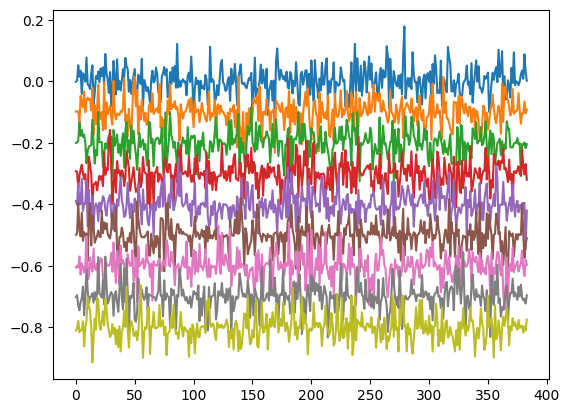

In [14]:
mat = model.transformer.wte.weight.detach().cpu().numpy()[17:26]
# plt.imshow(mat, cmap='Reds', interpolation='nearest')
import matplotlib.pyplot as plt
for i in range(9):
    plt.plot(mat[i]-i*0.1)

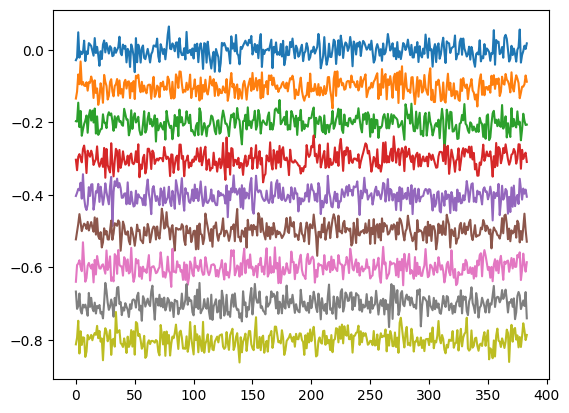

In [ ]:
mat = model.transformer.wte.weight.detach().cpu().numpy()[17:26]
# plt.imshow(mat, cmap='Reds', interpolation='nearest')
for i in range(9):
    plt.plot(mat[i]-i*0.1)

In [32]:
vecs, dists = GPT_nope.create_equal_distancing_vecotrs(3, 6, small_component=0.1)
dists[0]

array([ 1.       , -0.1627907, -0.1627907])

In [19]:

len(model_list), len(useful_name_list)

(123, 123)

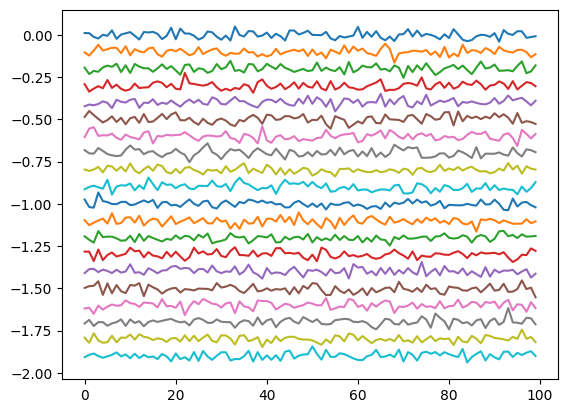

In [96]:
l = 100
mat = model_list[4].transformer.h[4].attn.c_attn.weight[:20, :l].detach().cpu().numpy()
# mat = model_list[4].transformer.h[4].attn.c_attn.weight[:l, :10].detach().cpu().numpy().T


for i in range(len(mat)):
    plt.plot(mat[i]-0.1*i)

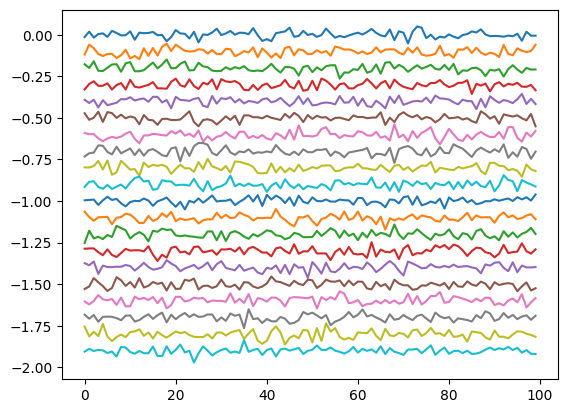

In [95]:
mat = model_list[4].transformer.h[0].attn.c_attn.weight[:20, :l].detach().cpu().numpy()

for i in range(len(mat)):
    plt.plot(mat[i]-0.1*i)

In [17]:
import ipywidgets as widgets
import gc
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

sim_func = cosine_similarity
# sim_func = lambda x, y: np.dot(x, y.T)
show_vals = False
print(f"using function {repr(sim_func).split(' ')[1]}")

def standardize_rows(matrix):
    """Standardize each row of the matrix."""
    mean = matrix.mean(axis=1, keepdims=True)
    std = matrix.std(axis=1, keepdims=True)
    return (matrix - mean) / std

level_corr_mat_accum = []
corr_mat = None
u1, u2, u1_name, u2_name = None, None, None, None

task_name = 'mod_'
folder_name = f'corr_{task_name}' if not equal_distancing_exp else f'dot_{task_name}'
folder_name += '_trained' if not model_init else '_init'

for k in ablation_config:
    if ablation_config[k]:
        if k == 'func_config':
            folder_name += f'_{ablation_config[k]}'
        else: 
            folder_name += f'_{k}' 

def get_corr(idx1, level=0, drop_down=[], save=False,  abs=True, save_all=False, accumulate_all=False, subplot_layers=True):
    global corr_mat, input_act1_list
    global u1, u2, u1_name, u2_name
    rand_state = 'init_' if model_init else ''

    if drop_down != []:
        idx1 = useful_name_list.index(drop_down)

    print(idx1, useful_name_list[idx1])

    if not (save_all or accumulate_all):
        if not subplot_layers:
            idx2 = idx1
            input_act1_list = all_level_input_act_list[level]
            u1, u2 = input_act1_list[idx1], input_act1_list[idx2]

            u1 = u1.T
            u2 = u2.T
            
            
            # print(useful_name_list[idx1][0].split('sd')[-1], useful_name_list[idx2][0].split('sd')[-1])

            print(u2.shape)

            if u2.shape[1] != 1:
                # Standardize each row of u1 and u2
                u1_standardized = standardize_rows(u1)
                u2_standardized = standardize_rows(u2)

                corr_mat = np.dot(u1_standardized, u2_standardized.T) / (u1.shape[1] )
            else:
                u1 = u1.reshape(-1, n_embd)
                u2 = u2.reshape(-1, n_embd)
                # import cosine similarity
                corr_mat = sim_func(u1, u2)

                # corr_mat = np.dot(u1, u2.T)

            if abs:
                corr_mat = np.abs(corr_mat)
            else:
                pass
            vec_dim = corr_mat.shape[0]//fixed_length
            total_sum = np.abs(corr_mat).sum()
            block_sum = 0
            for i in range(0, len(corr_mat), vec_dim):
                block_sum += np.abs(corr_mat[i:i+vec_dim, i:i+vec_dim]).sum()
            ratio = block_sum/(total_sum-block_sum)

            # Assuming you have calculated 'corr_mat' as described in the previous answer

            # Create a heatmap of corr_mat
            plt.figure(figsize=(6, 5), dpi=120)
            # plt.imshow(corr_mat, cmap='seismic') #, interpolation='nearest')
            plt.imshow(corr_mat, cmap='Reds') #, interpolation='nearest')

            extra_text = 'Absolute ' if abs else ''
            plt.colorbar(label=f'{extra_text}Correlation Coefficient', fraction=0.06, pad=0.04,)

            # Show the plot
            
            nope1 = 'nope_' if 'nope' in useful_name_list[idx1][1] else ''
            
            u1_name = '_'.join(useful_name_list[idx1][1].split('_')[2:])
            u1_name = nope1 + u1_name.split('_')[-1] + '_' + '_'.join(u1_name.split('_')[:-1])
            
            nope2 = 'nope_' if 'nope' in useful_name_list[idx1][1] else ''
            
            u2_name = '_'.join(useful_name_list[idx2][1].split('_')[2:])
            u2_name = nope2+u2_name.split('_')[-1] + '_' +'_'.join(u2_name.split('_')[:-1])

            extra_self = 'Self' if u1_name == u2_name else ''
            # plt.title(f'{extra_self} Correlation Matrix for  {ratio:.2f}')
            # print(u1_name, u2_name)
            if save:
                os.makedirs(f'./saved_plots_{folder_name}/', exist_ok=True)
                plt.savefig(f'./saved_plots_{folder_name}/{task_name+folder_name}_{rand_state}_{u2_name}_layer{level}_{ratio:.03f}_{abs}.svg')
            
            # close img
            # plt.close()
            plt.show()
        else:
            fig, axs = plt.subplots(1, len(all_level_input_act_list), figsize=(36, 5))  # 6 subplots in a row, adjust size as needed

            global_min, global_max = float('inf'), float('-inf')
            corr_mat_list= [ ]
            for level in range(len(all_level_input_act_list)):
                idx2 = idx1
                input_act1_list = all_level_input_act_list[level]
                u1, u2 = input_act1_list[idx1], input_act1_list[idx2]

                u1 = u1.T
                u2 = u2.T

                if u2.shape[1] != 1:
                    u1_standardized = standardize_rows(u1)
                    u2_standardized = standardize_rows(u2)
                    corr_mat = np.dot(u1_standardized, u2_standardized.T) / (u1.shape[1])
                else:
                    u1 = u1.reshape(-1, n_embd)
                    u2 = u2.reshape(-1, n_embd)
                    # corr_mat = np.dot(u1, u2.T)
                    corr_mat = sim_func(u1, u2)

                if abs:
                    corr_mat = np.abs(corr_mat)
                corr_mat_list.append(corr_mat)
                
                global_min = min(global_min, corr_mat.min())
                global_max = max(global_max, corr_mat.max())


            for level in range(len(all_level_input_act_list)):
                
                corr_mat = corr_mat_list[level]

                # vec_dim = n_embd
                vec_dim = corr_mat.shape[0]//fixed_length

                total_sum = np.abs(corr_mat).sum()
                block_sum = 0
                for i in range(0, len(corr_mat), vec_dim):
                    block_sum += np.abs(corr_mat[i:i+vec_dim, i:i+vec_dim]).sum()
                ratio = block_sum/(total_sum-block_sum)

                cm = axs[level].imshow(corr_mat, cmap='Reds') #, interpolation='nearest')
                
                # show the number on each block
                if show_vals:
                    for i in range(0, len(corr_mat), vec_dim):
                        for j in range(0, len(corr_mat), vec_dim):
                            text = axs[level].text(j, i, f'{corr_mat[i:i+vec_dim, j:j+vec_dim].sum():.02f}',
                                                ha="center", va="center", color="black", fontsize=6)
                axs[level].set_title(f'Layer {level}')
                plt.colorbar(cm, ax=axs[level], orientation='vertical', fraction=0.06, pad=0.04,)

            extra_text = 'Absolute ' if abs else ''

            
            nope1 = 'nope_' if 'nope' in useful_name_list[idx1][1] else ''
            
            u1_name = '_'.join(useful_name_list[idx1][1].split('_')[2:])
            u1_name = nope1 + u1_name.split('_')[-1] + '_' + '_'.join(u1_name.split('_')[:-1])
            
            nope2 = 'nope_' if 'nope' in useful_name_list[idx1][1] else ''
            
            u2_name = '_'.join(useful_name_list[idx2][1].split('_')[2:])
            u2_name = nope2+u2_name.split('_')[-1] + '_' +'_'.join(u2_name.split('_')[:-1])

            extra_self = 'Self' if u1_name == u2_name else ''
            # plt.title(f'{extra_self} Correlation Matrix for  {ratio:.2f}')
            # print(u1_name, u2_name)
            if save:
                os.makedirs(f'./saved_plots_{folder_name}/', exist_ok=True)
                plt.savefig(f'./saved_plots_{folder_name}/{task_name+folder_name}_{len(all_level_input_act_list)}layers_{rand_state}_{u2_name}_{ratio:.03f}_{abs}.svg')
            
            # close img
            # plt.close()
            plt.show()

    else:
        for idx1 in tqdm(range(len(input_act1_list))):
            corr_mat_list = []

            for level in range(len(all_level_input_act_list)):
                input_act1_list = all_level_input_act_list[level]
                global level_corr_mat_accum

                idx2 = idx1
                u1, u2 = input_act1_list[idx1], input_act1_list[idx2]
                u1 = u1.T
                u2 = u2.T
                
                if u2.shape[1] != 1:
                    u1_standardized = standardize_rows(u1)
                    u2_standardized = standardize_rows(u2)

                    corr_mat = np.dot(u1_standardized, u2_standardized.T) / (u1.shape[1] )
                else:
                    u1 = u1.reshape(-1, n_embd)
                    u2 = u2.reshape(-1, n_embd)
                    corr_mat = sim_func(u1, u2) 

                if abs:
                    corr_mat = np.abs(corr_mat)
                else:
                    pass
            
                if accumulate_all:
                    level_corr_mat_accum.append(corr_mat[None, ...])
                if not save_all:
                    continue 
                
                corr_mat_list.append(corr_mat)

                if not subplot_layers:
                    vec_dim = corr_mat.shape[0]//fixed_length
                    total_sum = np.abs(corr_mat).sum()
                    block_sum = 0
                    for i in range(0, len(corr_mat), vec_dim):
                        block_sum += np.abs(corr_mat[i:i+vec_dim, i:i+vec_dim]).sum()
                    ratio = block_sum/(total_sum-block_sum)

                    # Assuming you have calculated 'corr_mat' as described in the previous answer

                    # Create a heatmap of corr_mat
                    plt.figure(figsize=(6, 5), dpi=120)
                    # plt.imshow(corr_mat, cmap='seismic') #, interpolation='nearest')
                    plt.imshow(corr_mat, cmap='Reds') #, interpolation='nearest')

                    extra_text = 'Absolute ' if abs else ''
                    plt.colorbar(label=f'{extra_text}Correlation Coefficient')

                    # Set axis labels and title
                    # plt.xlabel('U2 Entries')
                    # plt.ylabel('U1 Entries')

                    # Show the plot
                    
                    nope1 = 'nope_' if 'nope' in useful_name_list[idx1][1] else ''
                    
                    u1_name = '_'.join(useful_name_list[idx1][1].split('_')[2:])
                    u1_name = nope1 + u1_name.split('_')[-1] + '_' + '_'.join(u1_name.split('_')[:-1])
                    
                    nope2 = 'nope_' if 'nope' in useful_name_list[idx1][1] else ''
                    
                    u2_name = '_'.join(useful_name_list[idx2][1].split('_')[2:])
                    u2_name = nope2+u2_name.split('_')[-1] + '_' +'_'.join(u2_name.split('_')[:-1])

                    extra_self = 'Self' if u1_name == u2_name else ''
                    # plt.title(f'{extra_self} Correlation Matrix for  {ratio:.2f}')
                    # print(ratio)
                    # # print(u1_name, u2_name)
                    os.makedirs(f'./saved_plots_{folder_name}/', exist_ok=True)
                    # plt.savefig(f'./saved_plots_{folder_name}/{task_name+folder_name}_{rand_state}_{u2_name}_layer{level}_{ratio:.03f}_{abs}.svg')
                    plt.savefig(f'./saved_plots_{folder_name}/{useful_name_list[idx1]}_avg_{abs}.svg')
                    
                    # close img
                    plt.close()

            if subplot_layers:
                acc = useful_name_list[idx1].split('_')[0]
                rest = '_'.join(useful_name_list[idx1].split('_')[1:])
                imgname = rest.replace('10000_acc_', '').replace('/', '_').replace('.pt', '') + '_' + acc
                if f'./saved_plots_{folder_name}/{imgname}.svg' in glob.glob(f'./saved_plots_{folder_name}/*.svg'):
                    continue
                fig, axs = plt.subplots(1, len(all_level_input_act_list), figsize=(40, 5))  # 6 subplots in a row, adjust size as needed
                for level in range(len(all_level_input_act_list)):
                    
                    corr_mat = corr_mat_list[level]

                    # vec_dim = n_embd
                    vec_dim = corr_mat.shape[0]//fixed_length

                    total_sum = np.abs(corr_mat).sum()
                    block_sum = 0
                    for i in range(0, len(corr_mat), vec_dim):
                        block_sum += np.abs(corr_mat[i:i+vec_dim, i:i+vec_dim]).sum()
                    ratio = block_sum/(total_sum-block_sum)

                    cm = axs[level].imshow(corr_mat, cmap='Reds') #, interpolation='nearest')
                    # show the number on each block
                    if show_vals:
                        for i in range(0, len(corr_mat), vec_dim):
                            for j in range(0, len(corr_mat), vec_dim):
                                text = axs[level].text(j, i, f'{corr_mat[i:i+vec_dim, j:j+vec_dim].sum():.02f}',
                                                    ha="center", va="center", color="black", fontsize=6)

                    
                    title_text = f'Layer {level}' if level > 0 else 'Token Embeddings'                
                    axs[level].set_title(title_text)
                    plt.colorbar(cm, ax=axs[level], orientation='vertical', fraction=0.06, pad=0.04,)

                os.makedirs(f'./saved_plots_{folder_name}/', exist_ok=True)
                

                plt.savefig(f'./saved_plots_{folder_name}/{imgname}.svg')
                plt.close()
                gc.collect()


            # if idx1 >=10:
            #     raise ValueError
            if accumulate_all:
                level_corr_mat_accum = np.vstack(level_corr_mat_accum)
                print(level_corr_mat_accum.shape)
                level_corr_mat_accum = level_corr_mat_accum.mean(axis=0)
                # Create a heatmap of corr_mat
                if not subplot_layers:
                    plt.figure(figsize=(6, 5), dpi=120)
                    # plt.imshow(corr_mat, cmap='seismic') #, interpolation='nearest')
                    plt.imshow(level_corr_mat_accum, cmap='Reds') #, interpolation='nearest')

                    extra_text = 'Absolute ' if abs else ''
                    plt.colorbar(label=f'{extra_text}Correlation Coefficient')
                    plt.show()
                corr_mat  =  level_corr_mat_accum
                level_corr_mat_accum = []
            
           


# all_drop_down = [e[1] for e in useful_name_list]

widgets.interact(get_corr, idx1=(0, len(input_act1_list)-1), drop_down=useful_name_list, level=(0,5))
widgets.interact(get_corr, idx1=(0, len(input_act1_list)-1),  drop_down=useful_name_list, level=(0,5))


# idxes = [
# # [0,0], [0,1], [0,2], [0,3], [0,4],
# # [1,1], [2,2], [3,3], [4,4],
# # [4,1], [4,2], [4,3], 
# [1,2], [1,3],c
# ]
# from tqdm.auto import tqdm
# for idx1, idx2 in tqdm(idxes):
#     get_corr(idx1, idx2, save=True)
    
# all residual vs picking ones that are illustrative

using function cosine_similarity


interactive(children=(IntSlider(value=43, description='idx1', max=87), IntSlider(value=0, description='level',…

interactive(children=(IntSlider(value=43, description='idx1', max=87), IntSlider(value=0, description='level',…

<function __main__.get_corr(idx1, level=0, drop_down=[], save=False, abs=True, save_all=False, accumulate_all=False, subplot_layers=True)>

In [16]:
f'./saved_plots_{folder_name}'

'./saved_plots_corr_mod__trained'

In [71]:
model_list[26].transformer.h[1].randx[:6]
# model_list[].config


tensor([5, 4, 2, 1, 0, 3], device='cuda:0')

In [42]:
model_list[30 ].transformer.h[0].res1_weight


Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)

In [45]:
model_list[26 ].transformer.h[0].res2_weight


Parameter containing:
tensor([0.7706], device='cuda:0', requires_grad=True)

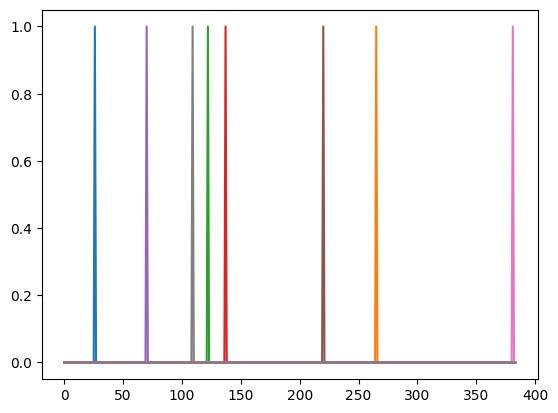

In [24]:
# eqx = torch.tensor(model.create_equal_distancing_vecotrs(8, n_embd, small_component=0.1)[0]).to(device).to(torch.float32)[None,...]
eqx = torch.tensor(model.create_equal_distancing_vecotrs(8, n_embd, small_component=0.0)[0]).to(device).to(torch.float32)[None,...] 
# maybe the attention won't matter, and it is still the same when using averaging

for s in eqx[0]:
    plt.plot(s.detach().cpu().numpy())

In [20]:
eqx = torch.tensor(model.create_equal_distancing_vecotrs(8, n_embd, small_component=0.0)[0]).to(device).to(torch.float32)[None,...] * 0.1


(torch.Size([1, 1, 384]), torch.Size([1, 8, 384]))

### Manual Attention

0


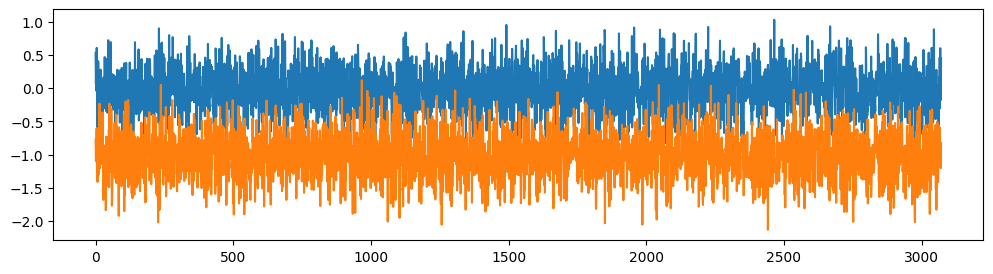

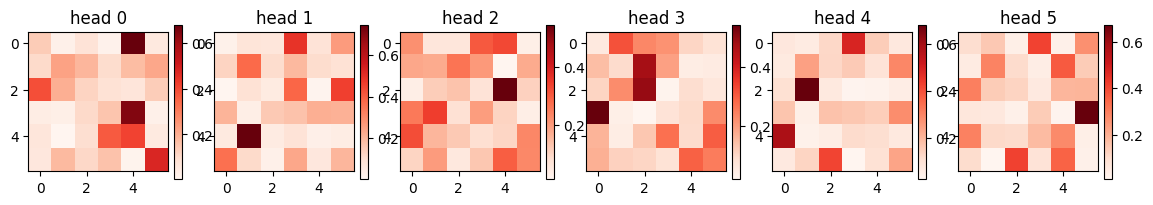

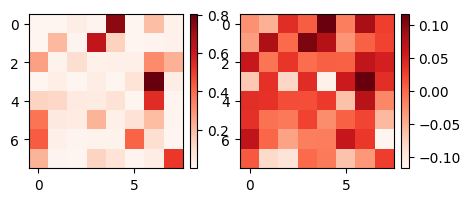

tensor(1., device='cuda:0') tensor(822.4888, device='cuda:0') tensor(844.0933, device='cuda:0') tensor(822.8871, device='cuda:0')


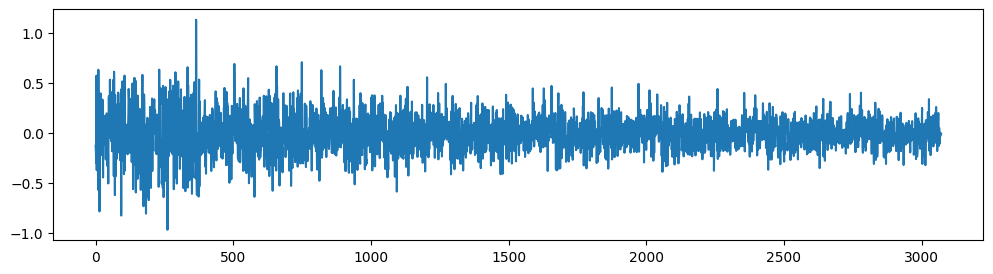

0


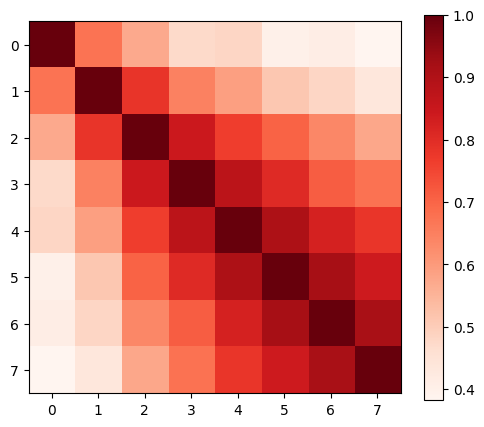

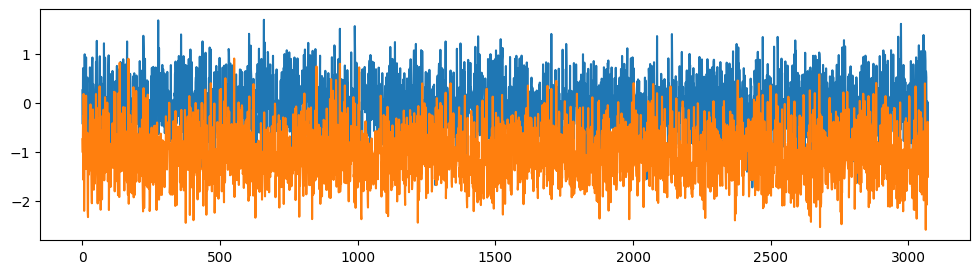

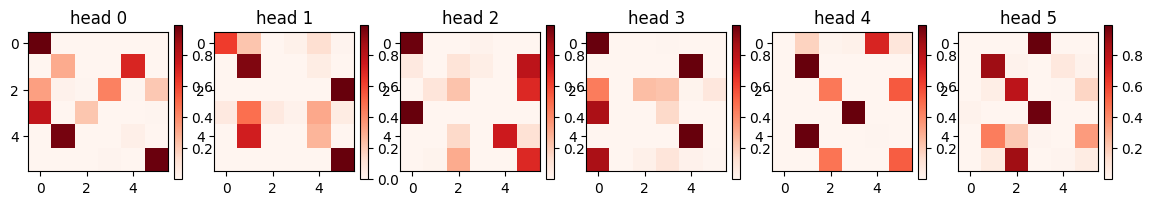

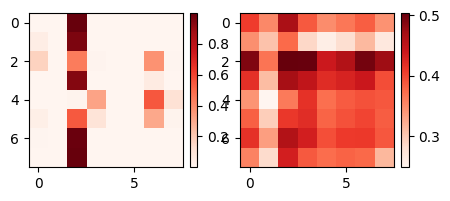

tensor(1., device='cuda:0') tensor(1319.5132, device='cuda:0') tensor(1412.3011, device='cuda:0') tensor(1187.0654, device='cuda:0')


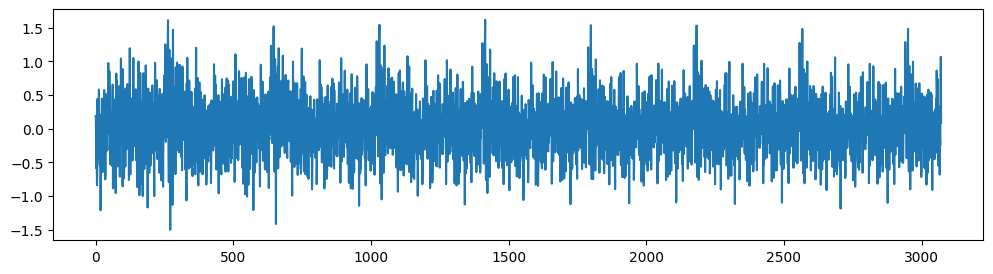

0


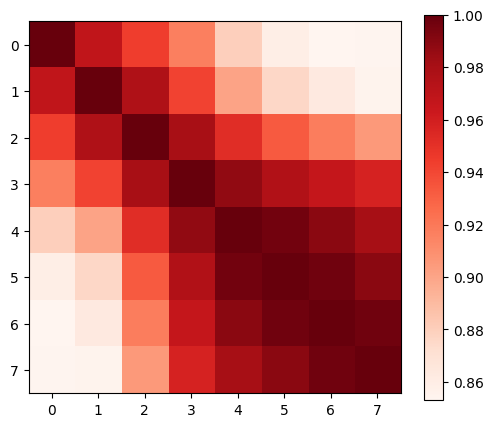

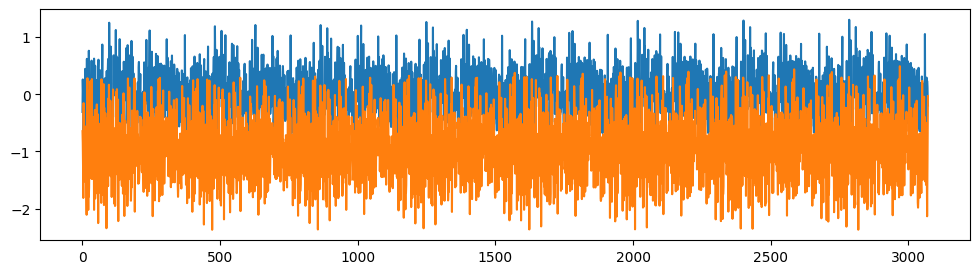

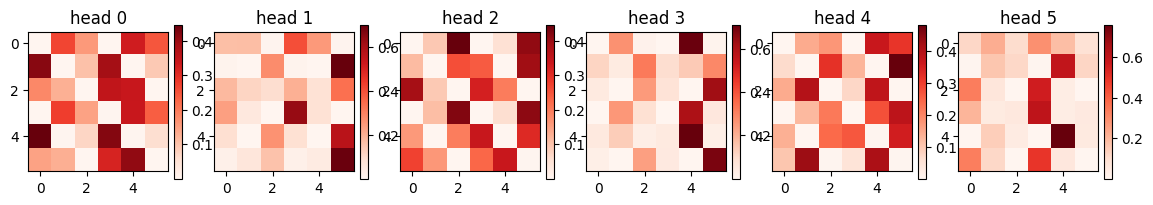

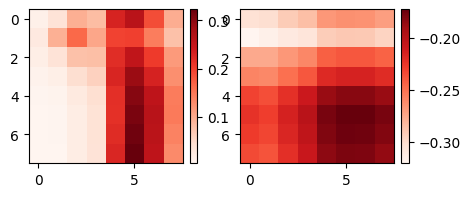

tensor(1., device='cuda:0') tensor(1033.7932, device='cuda:0') tensor(1446.4644, device='cuda:0') tensor(930.5189, device='cuda:0')


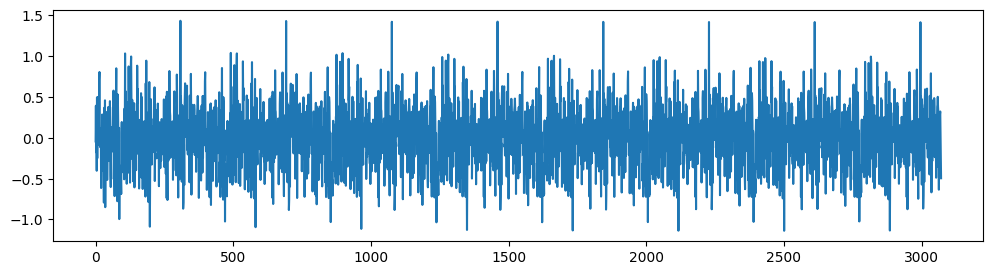

0


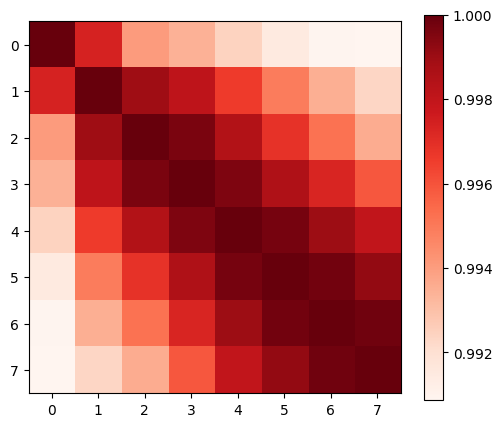

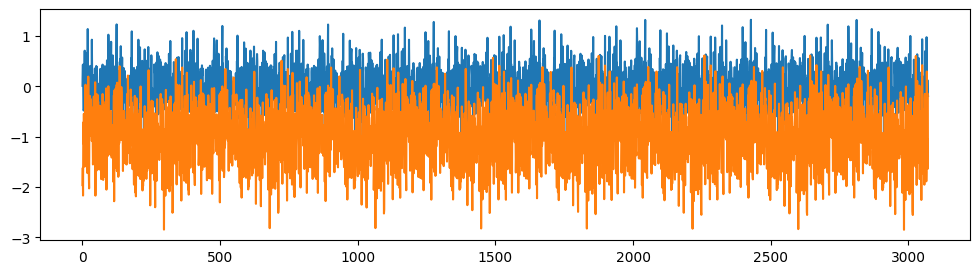

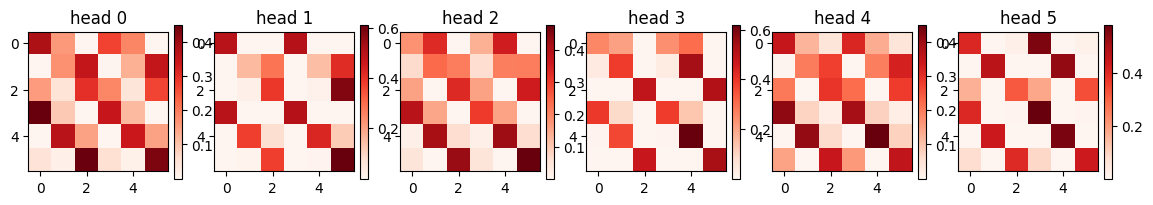

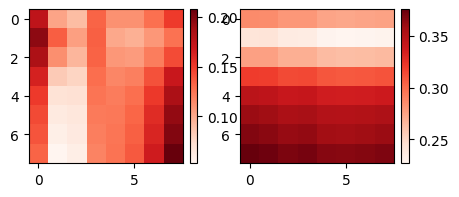

tensor(1., device='cuda:0') tensor(984.0132, device='cuda:0') tensor(1489.9630, device='cuda:0') tensor(951.9885, device='cuda:0')


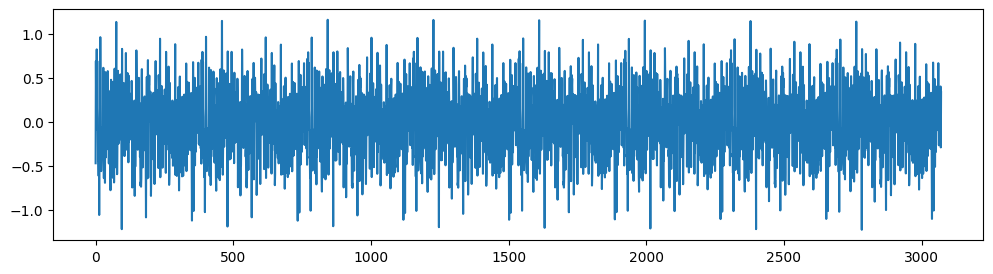

0


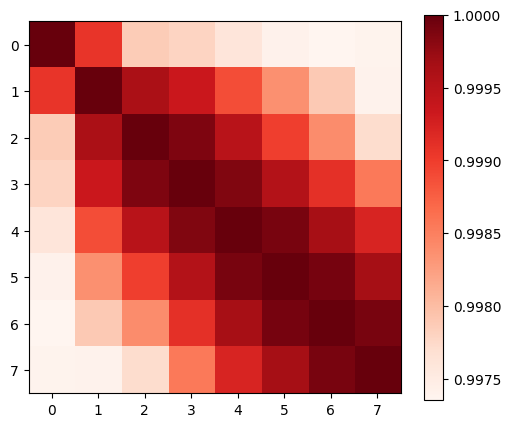

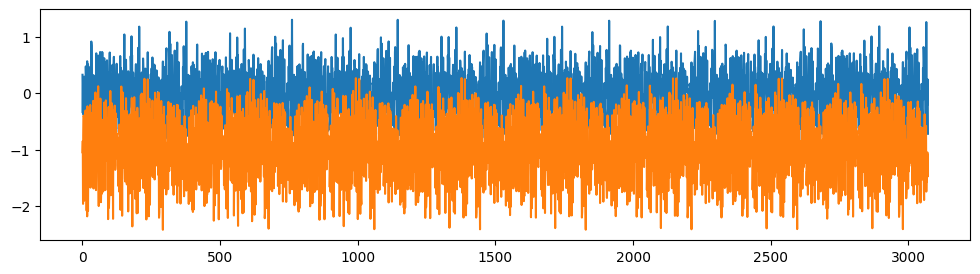

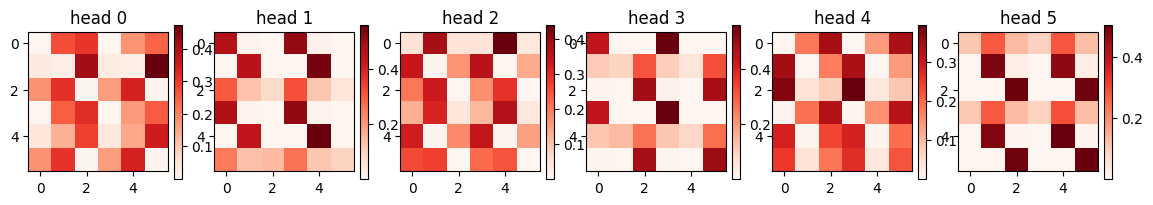

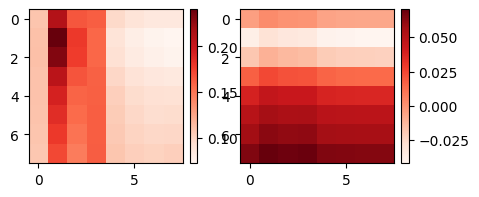

tensor(1., device='cuda:0') tensor(1088.4784, device='cuda:0') tensor(1426.1836, device='cuda:0') tensor(992.1417, device='cuda:0')


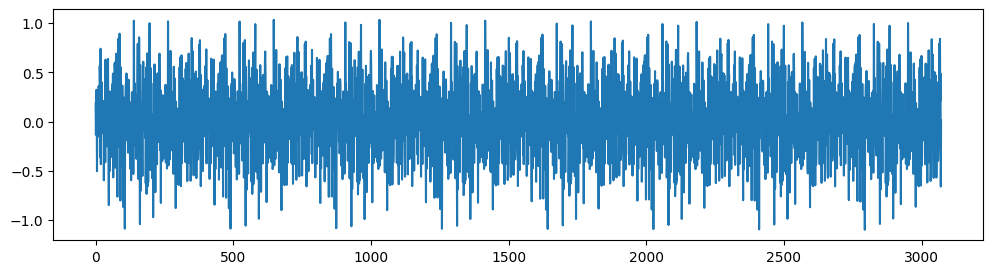

0


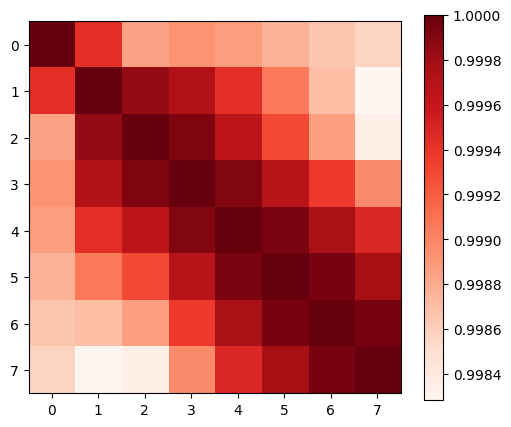

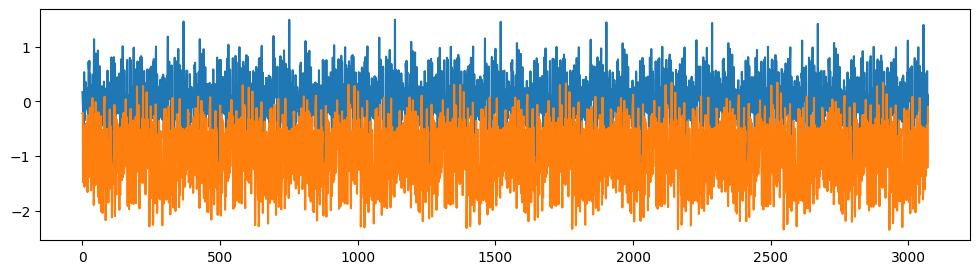

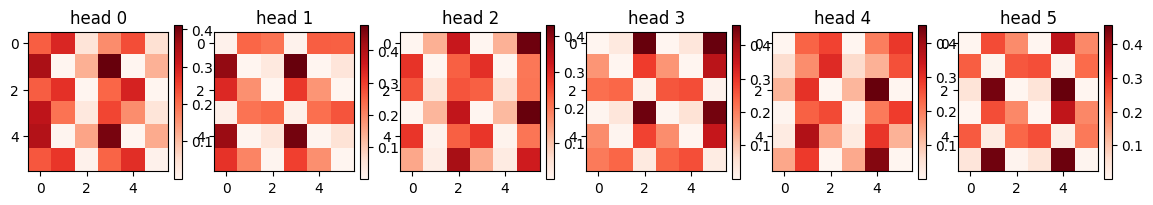

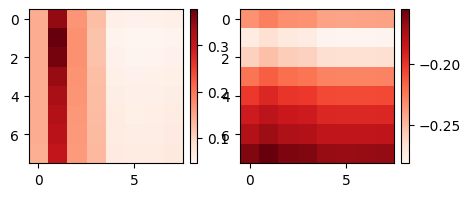

tensor(1., device='cuda:0') tensor(1120.5031, device='cuda:0') tensor(1392.9902, device='cuda:0') tensor(1057.2849, device='cuda:0')


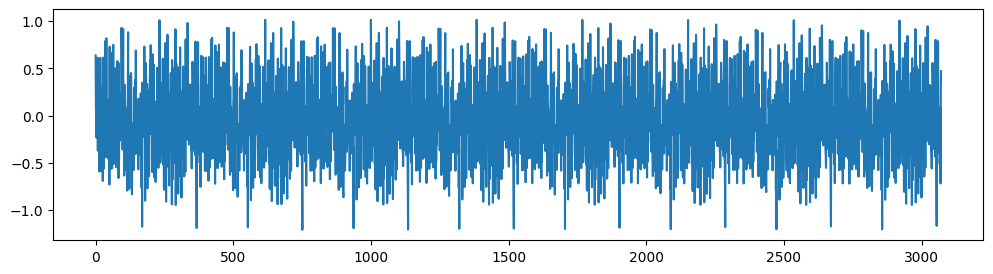

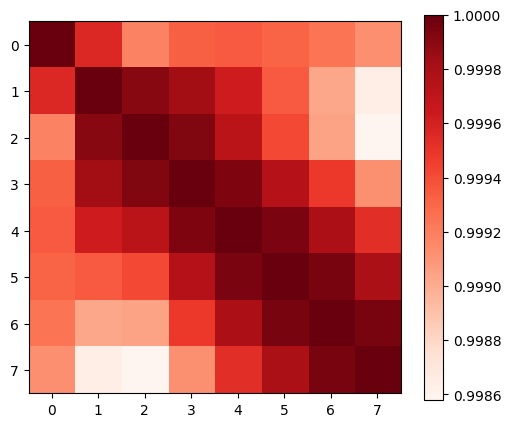

In [37]:
# the difference in projection for the same vector
# x = torch.rand(1, 1, 384).to(device)
n_embd = 384
x = torch.zeros(1, 1, n_embd).to(device)
sc = torch.rand(1, 1, n_embd).to(device)

idx = np.random.randint(0, n_embd)

x[0, 0, idx] = 1
# x += sc
# y = model_list[17].transformer.h[1].attn.c_attn(x)
# input_idx = torch.tensor(encode('12modp(123)=')).to(device)[None,...]
input_idx = torch.tensor(encode('$123+456=')).to(device)[None,...]

# eqx = torch.tensor(model.create_equal_distancing_vecotrs(8, n_embd, small_component=0.1)[0]).to(device).to(torch.float32)[None,...] * 0.1

eqx = torch.tensor(model.create_equal_distancing_vecotrs(8, n_embd, small_component=0.0)[0]).to(device).to(torch.float32)[None,...] * 0.1


# cur_model = model_list[12]
cur_model = model_list[2]
# cur_model = model_list[24]


for level in range(len(cur_model.transformer.h)):
    activation = {}

    def getActivation(name):
        # the hook signature
        def hook(model, input, output):
            activation[name] = output.detach()

        return hook

    h1 = cur_model.transformer.h[level].attn.c_attn.register_forward_hook(
        getActivation(f"layer_{level}")
    )
    

    h2 = cur_model.transformer.h[level].attn.identity.register_forward_hook(
        getActivation(f"layer_{level}_identity")
    )

    with torch.no_grad():


        out = cur_model(input_idx)
        # decode and print out
        y = decode([out[0].detach().cpu().numpy().argmax()])
        print(y)
        _ = cur_model(eqx, direct_input_modification=True)
        # _ = cur_model(x, direct_input_modification=True)



    

    h1.remove()
    h2.remove()
    y = activation[f"layer_{level}"]

    q, k, v  = y.split(n_embd, dim=2)
    plt.figure(figsize=(12, 3))
    plt.plot(q.detach().cpu().numpy().flatten())
    plt.plot(k.detach().cpu().numpy().flatten()-1)
    plt.show()

    fig, ax = plt.subplots(1, cur_model.config.n_head, figsize=(14, 2))
    q_reshape = q.reshape(1, cur_model.config.n_head, -1, n_embd//cur_model.config.n_head)
    k_reshape = k.reshape(1, cur_model.config.n_head, -1, n_embd//cur_model.config.n_head)
    for i in range(cur_model.config.n_head):
        mat = ax[i].imshow((torch.nn.Softmax(dim=-1)(q_reshape[0, :, i, :]@k_reshape[0, :, i, :].transpose(0,1))).detach().cpu().numpy(), cmap='Reds', interpolation='nearest')
        ax[i].set_title(f'head {i}')
        plt.colorbar(mat, ax=ax[i], orientation='vertical', fraction=0.06, pad=0.04,)
    plt.show()
        

    fig, ax = plt.subplots(1, 2, figsize=(5, 2))
    # plt.figure(figsize=(2, 5))
    mat = ax[0].imshow((torch.nn.Softmax(dim=-1)(q@k.transpose(1, 2))).detach().cpu().numpy()[0], cmap='Reds', interpolation='nearest')
    plt.colorbar(mat, ax=ax[0], orientation='vertical', fraction=0.06, pad=0.04,)

    # plt.colorbar()

    q_ = q.detach().cpu().numpy()[0]
    k_ = k.detach().cpu().numpy()[0]
    mat = cosine_similarity(q_, k_)

    mat = ax[1].imshow(mat, cmap='Reds', interpolation='nearest')
    plt.colorbar(mat, ax=ax[1], orientation='vertical', fraction=0.06, pad=0.04,)
    plt.show()


    print(x.sum(), q.abs().sum(), k.abs().sum(), v.abs().sum())

    y = activation[f"layer_{level}_identity"].detach().cpu().numpy()
    plt.figure(figsize=(12, 3))
    plt.plot(y.flatten())
    plt.show()

    plt.figure(figsize=(6, 5))
    mat = cosine_similarity(y[0], y[0])
    plt.imshow(mat, cmap='Reds', interpolation='nearest')
    plt.colorbar()
    



### Manual Avg

In [42]:
calc.shape, v.shape

(torch.Size([1, 8, 8]), torch.Size([1, 8, 384]))

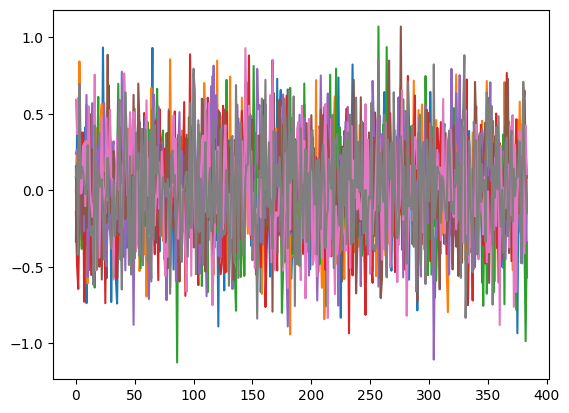

In [47]:
# plt.pcolormesh(v[0].detach().cpu().numpy(), cmap='viridis')
for c in v[0].detach().cpu().numpy():
    plt.plot(c)

In [89]:
(k_reshape.transpose(1, 2)).shape
# q_reshape@k_reshape.transpose(1, 2)
torch.einsum('bhid,bhjd->bhij', q_reshape, k_reshape).shape

torch.Size([1, 6, 9, 9])

tensor(0.1111)


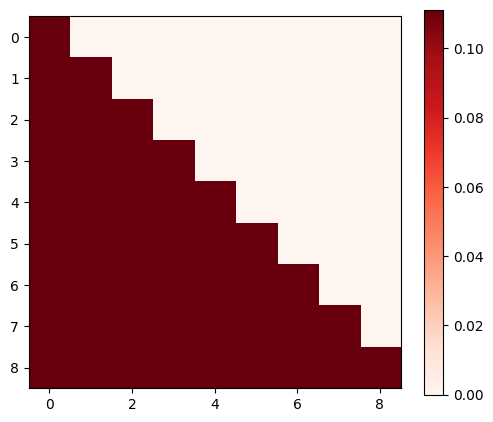

In [100]:
calc = torch.nn.Softmax(dim=-1)(torch.einsum('bhid,bhjd->bhij', q_reshape, k_reshape))
calc = torch.ones_like(calc) * calc.mean()
mask = np.triu(np.ones_like(calc[0].detach().cpu().numpy(), dtype=bool))[None, ...]
mask = torch.tensor(mask).to(device)

digit = calc[0, 0, 0,0 ].detach().cpu().clone()
print(digit)
calc[mask] = 0 
# for i in range(calc.shape)
#     calc[0, 0].diagonal().fill_(digit)
T = calc.shape[-1]
calc[:,:,np.arange(T),np.arange(T)] = digit

plt.figure(figsize=(6, 5))
plt.imshow(calc[0,0].detach().cpu().numpy(), cmap='Reds', interpolation='nearest')
plt.colorbar()
plt.show()

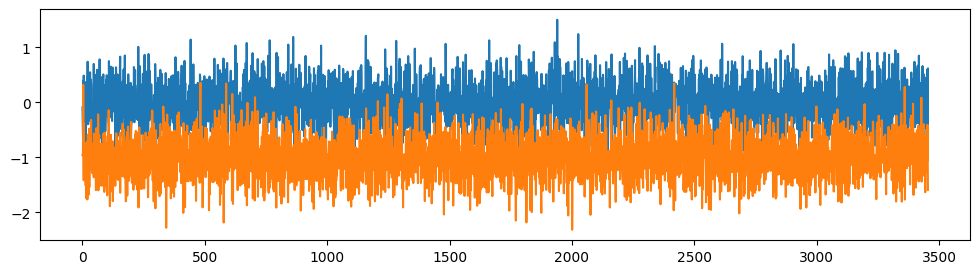

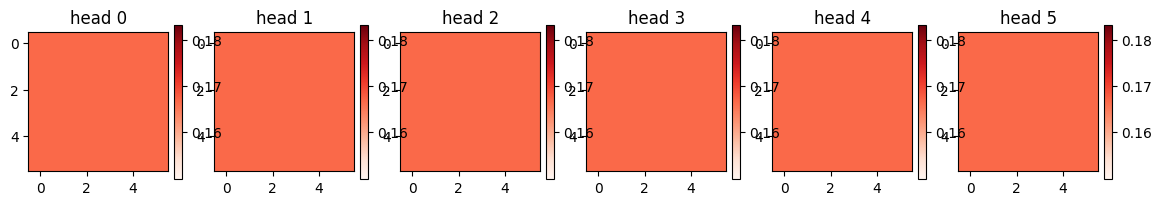

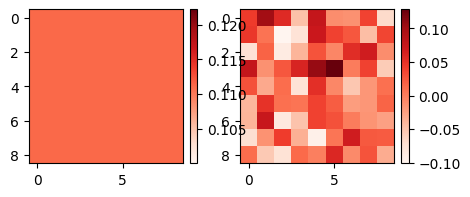

tensor(180.6570, device='cuda:0') tensor(1073.1592, device='cuda:0') tensor(1055.9957, device='cuda:0') tensor(1076.7761, device='cuda:0')


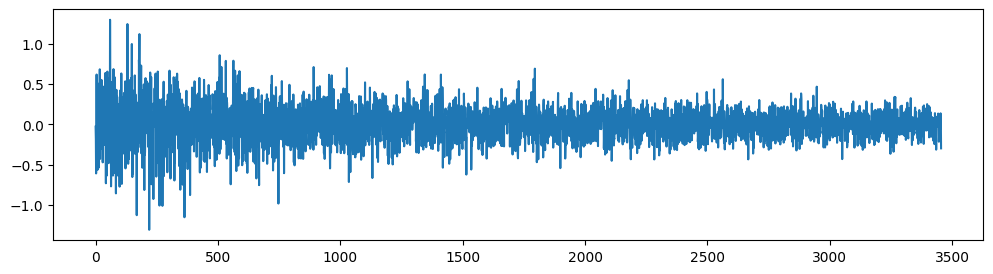

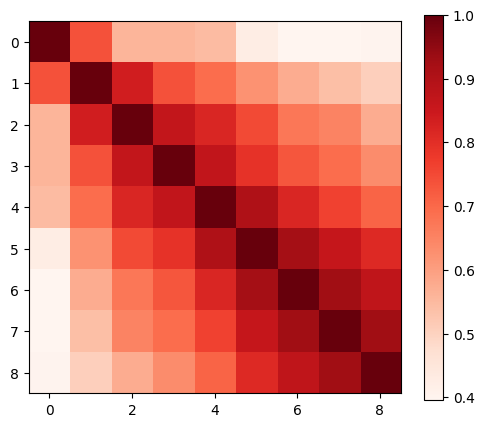

<Figure size 600x500 with 0 Axes>

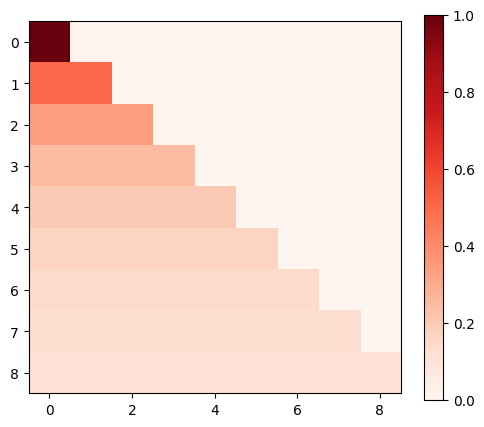

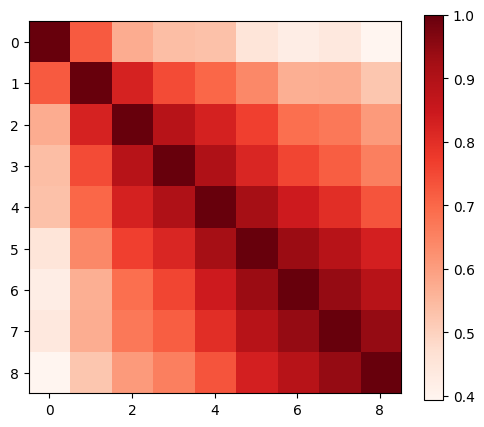

tensor(0.1111)


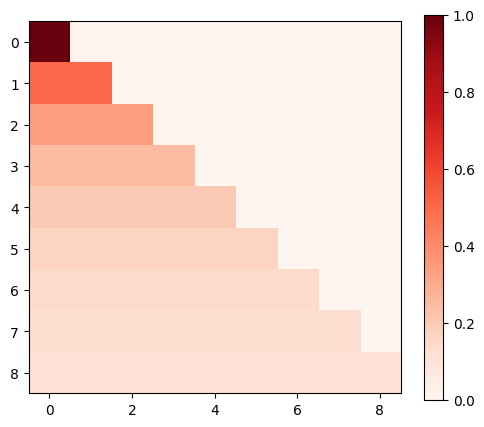

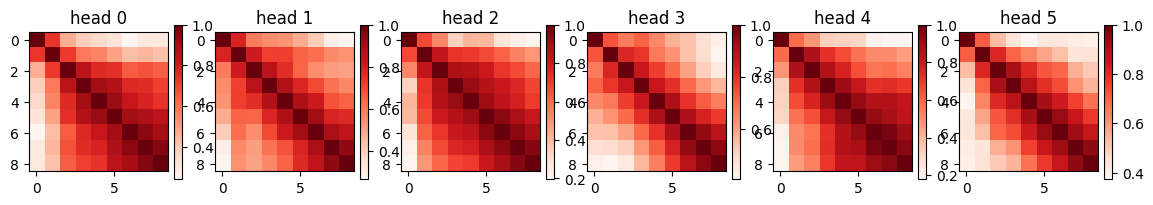

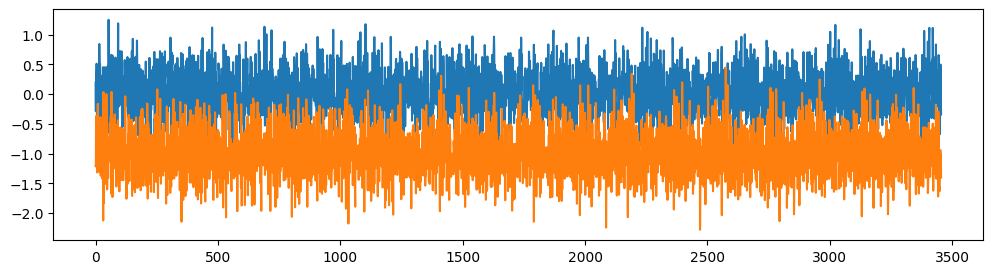

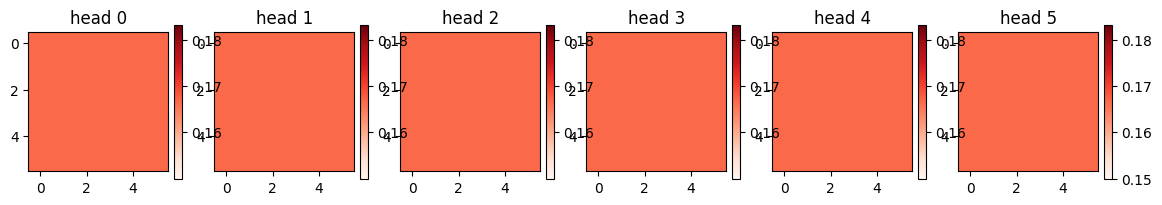

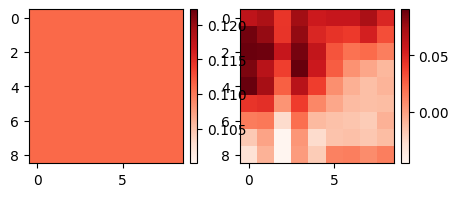

tensor(180.6570, device='cuda:0') tensor(1084.9073, device='cuda:0') tensor(1104.5918, device='cuda:0') tensor(1104.5854, device='cuda:0')


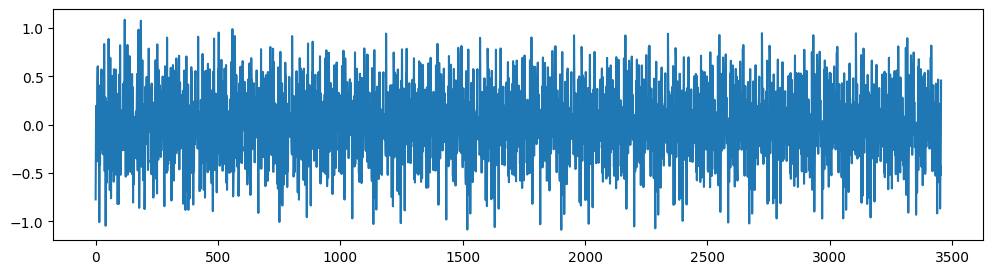

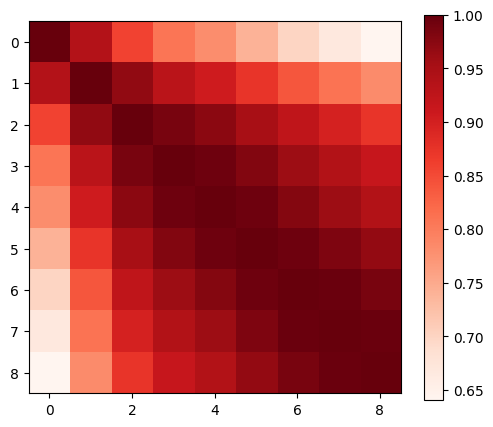

<Figure size 600x500 with 0 Axes>

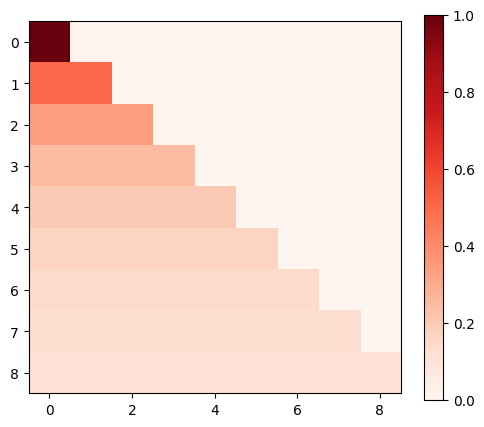

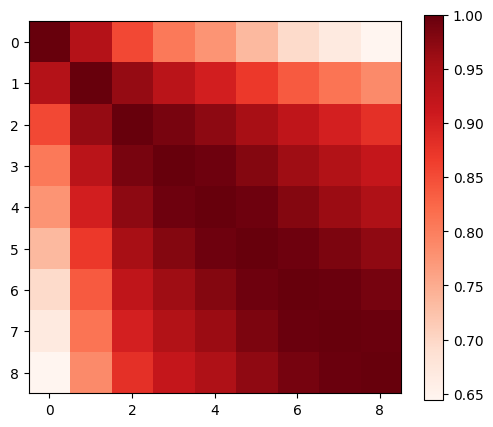

tensor(0.1111)


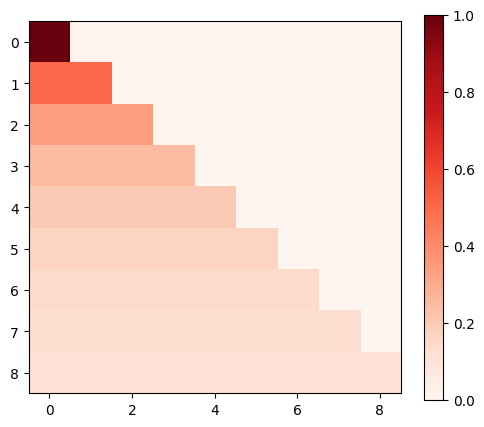

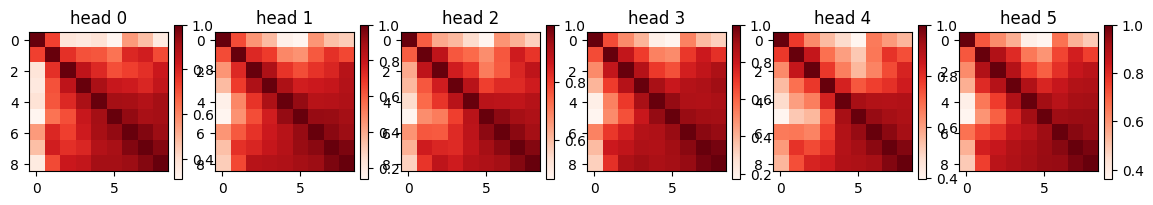

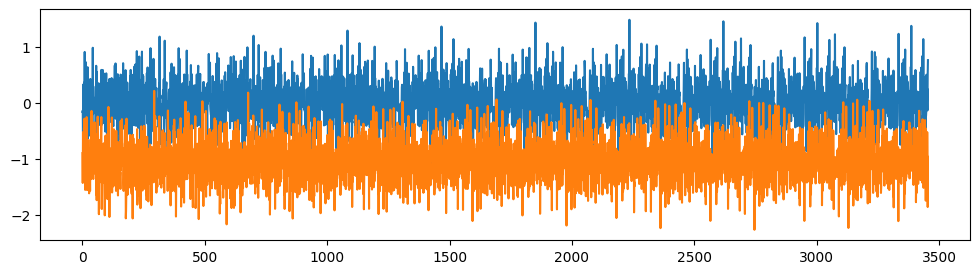

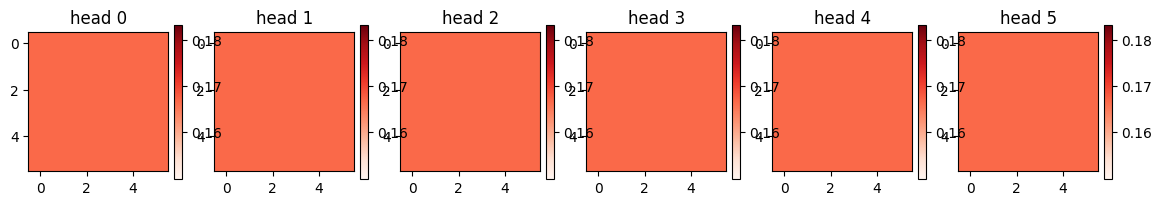

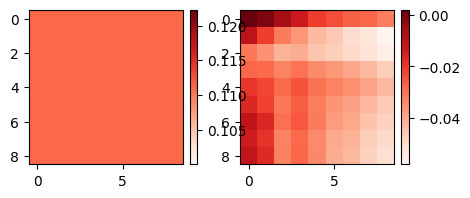

tensor(180.6570, device='cuda:0') tensor(1054.2760, device='cuda:0') tensor(1115.5713, device='cuda:0') tensor(1067.0363, device='cuda:0')


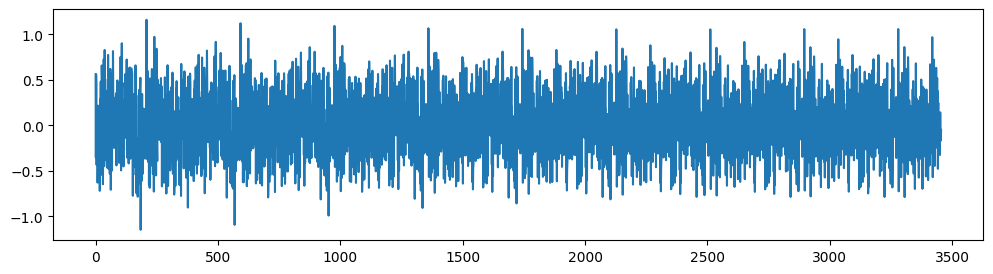

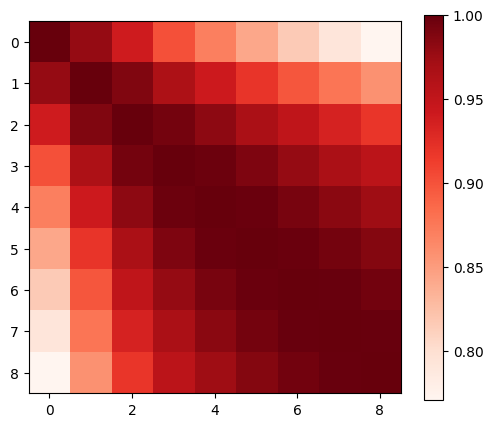

<Figure size 600x500 with 0 Axes>

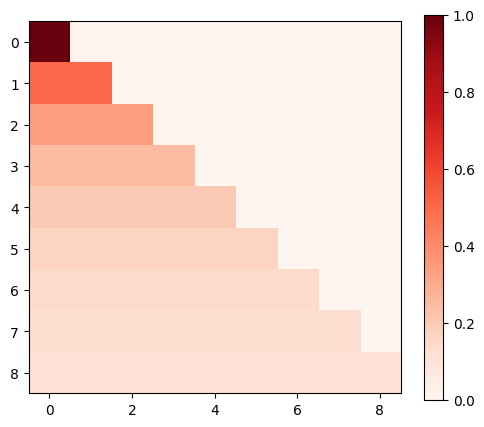

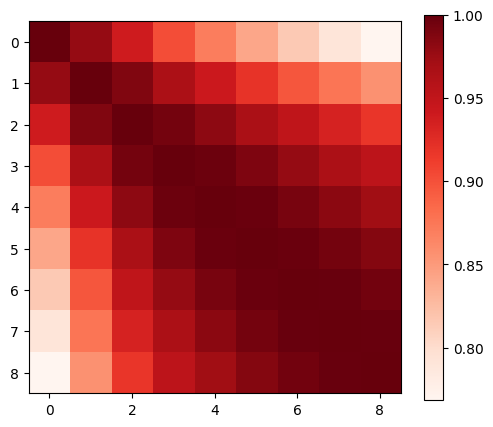

tensor(0.1111)


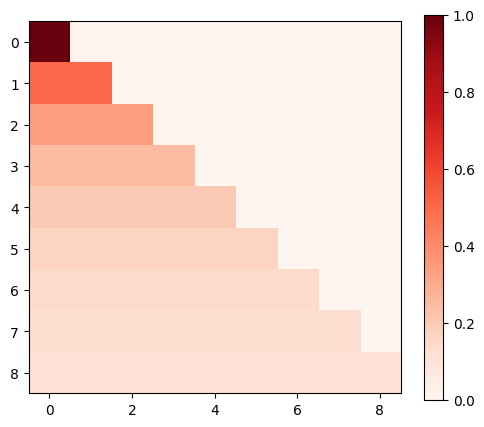

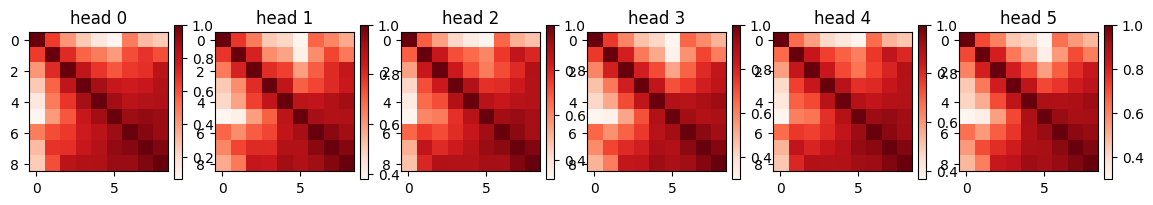

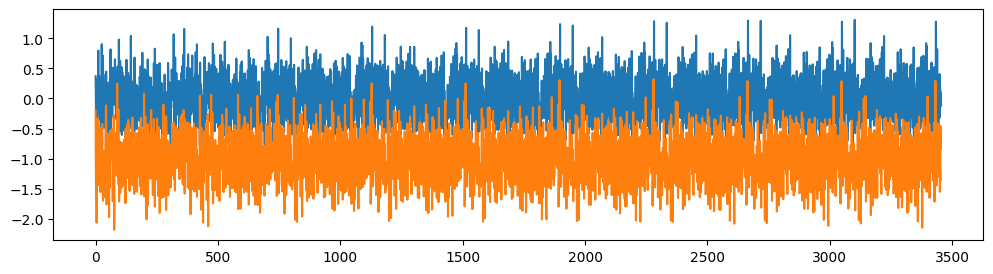

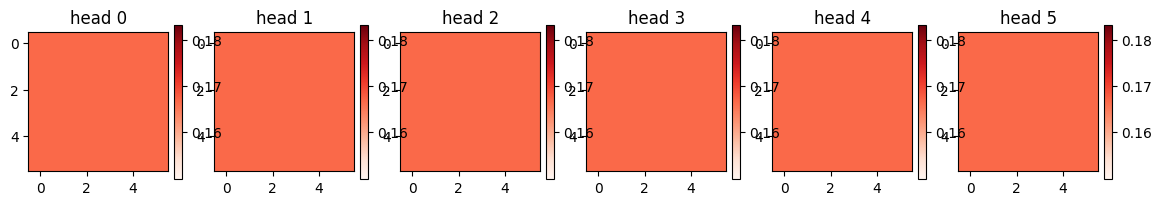

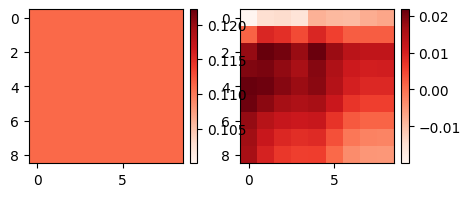

tensor(180.6570, device='cuda:0') tensor(1072.9309, device='cuda:0') tensor(1105.8374, device='cuda:0') tensor(1130.3580, device='cuda:0')


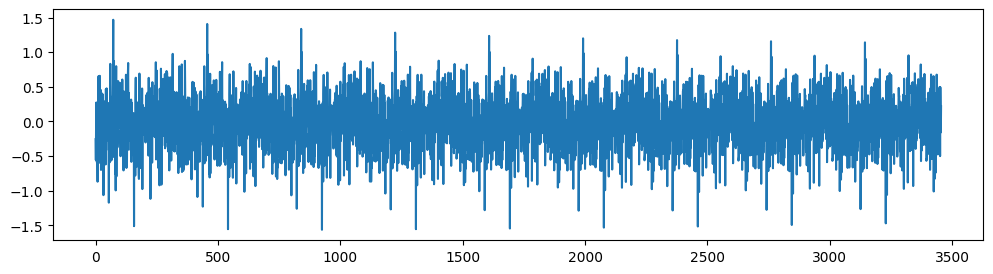

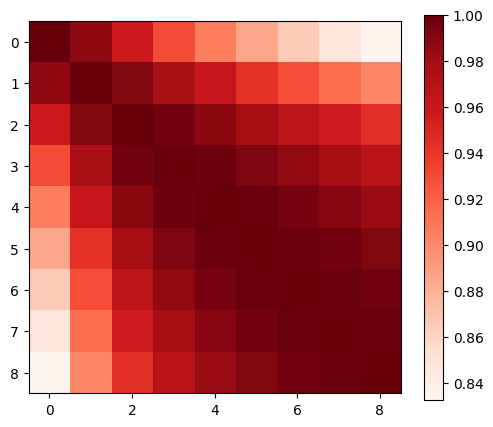

<Figure size 600x500 with 0 Axes>

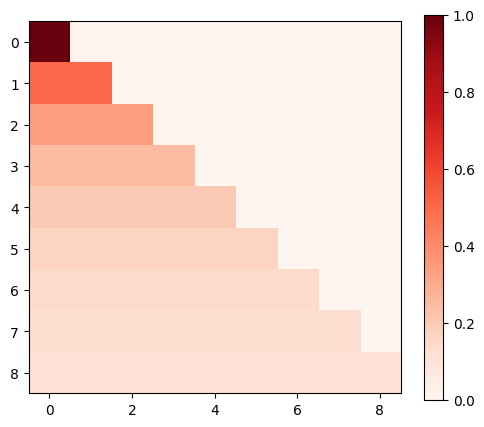

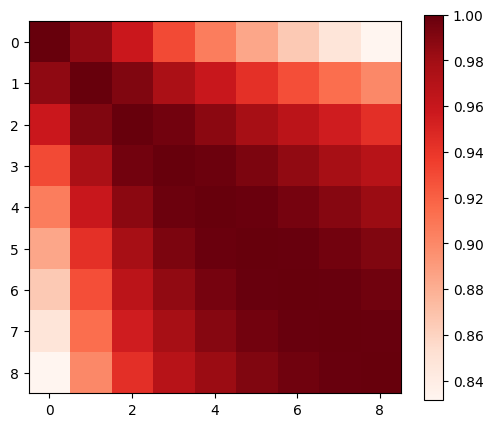

tensor(0.1111)


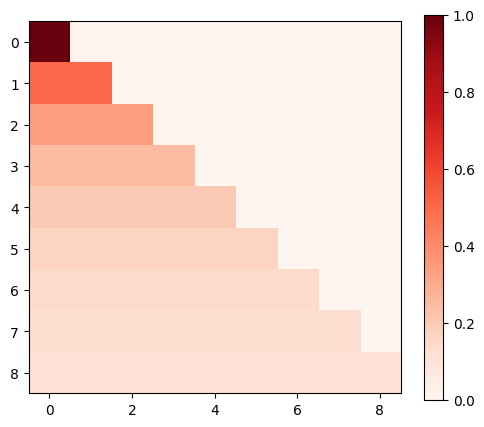

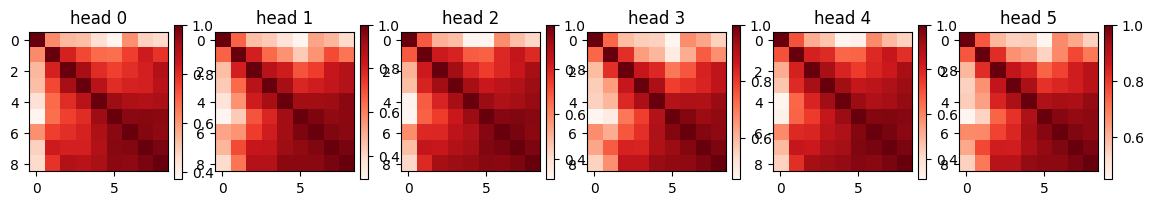

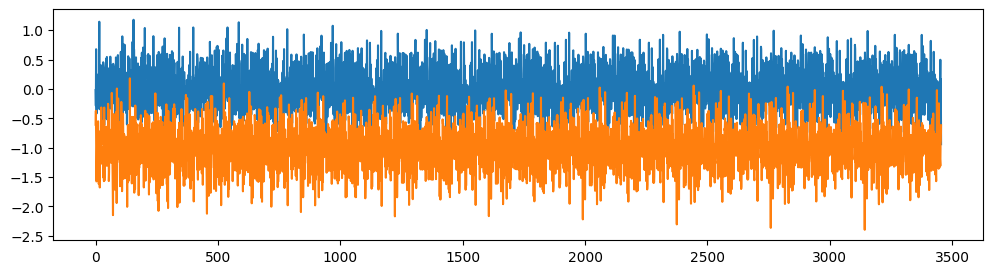

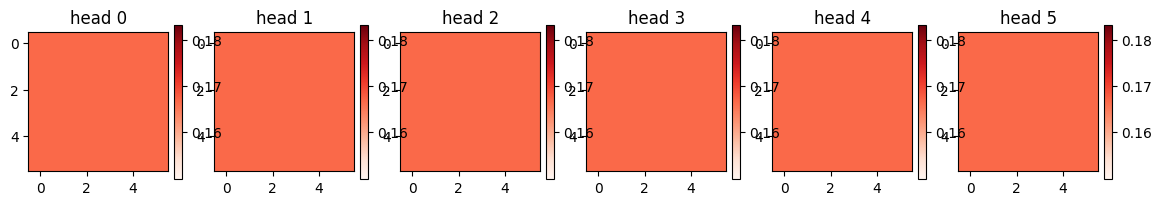

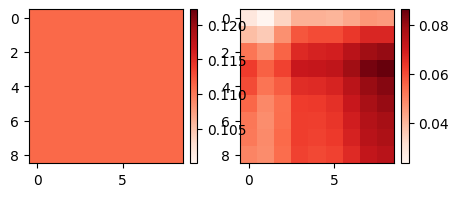

tensor(180.6570, device='cuda:0') tensor(1030.1758, device='cuda:0') tensor(1073.8451, device='cuda:0') tensor(1070.1531, device='cuda:0')


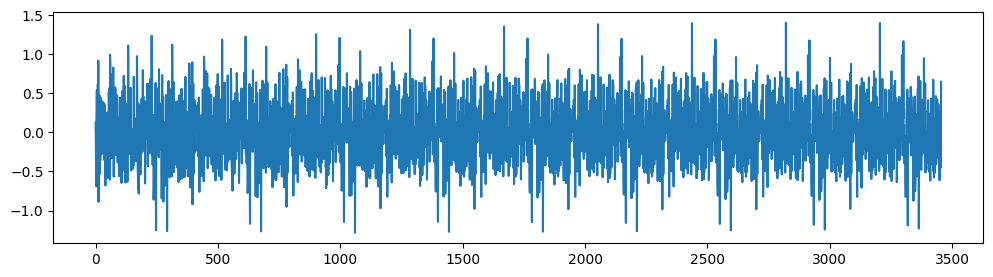

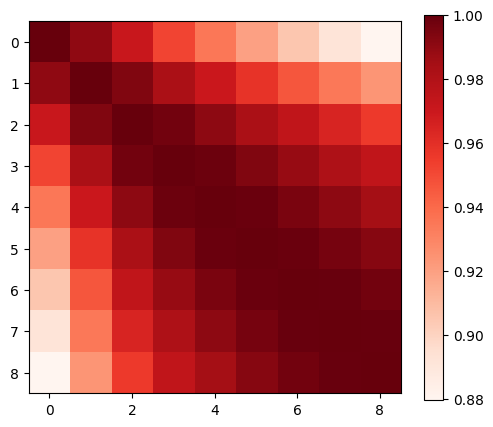

<Figure size 600x500 with 0 Axes>

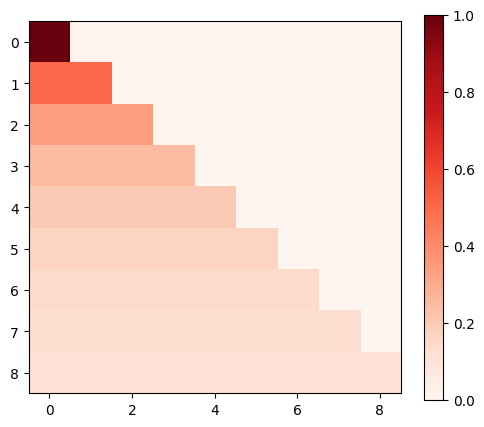

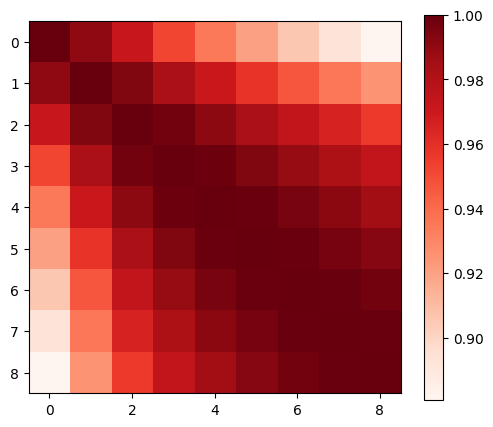

tensor(0.1111)


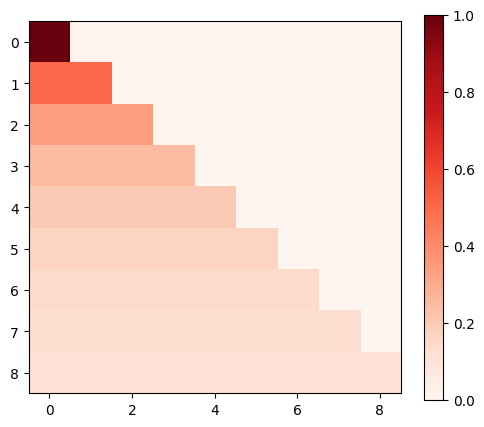

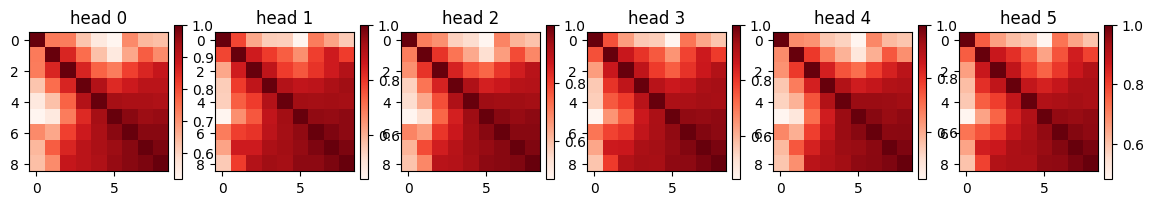

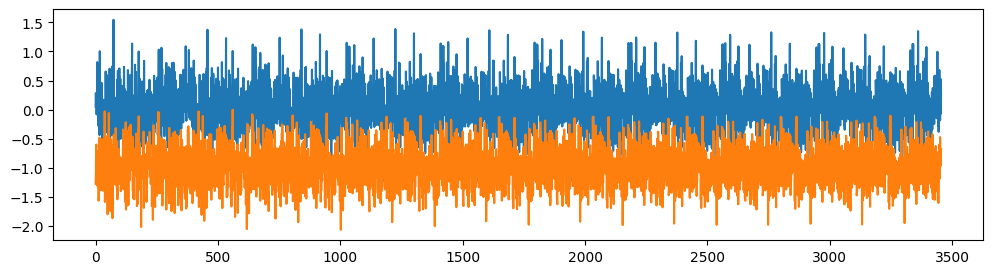

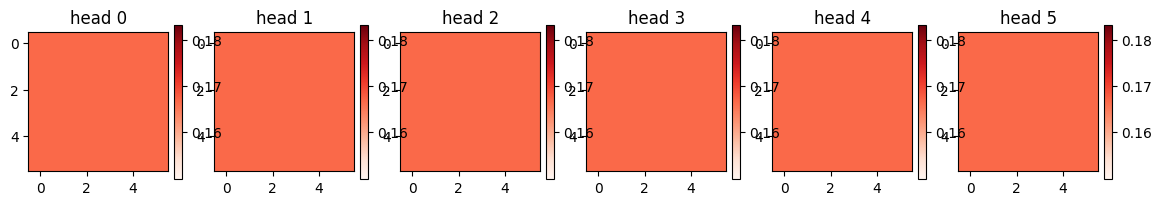

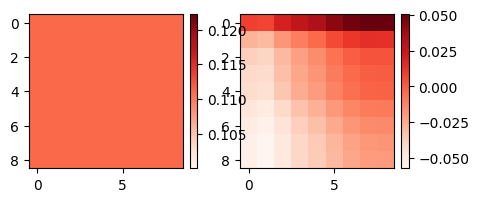

tensor(180.6570, device='cuda:0') tensor(1080.6331, device='cuda:0') tensor(995.1613, device='cuda:0') tensor(1049.6069, device='cuda:0')


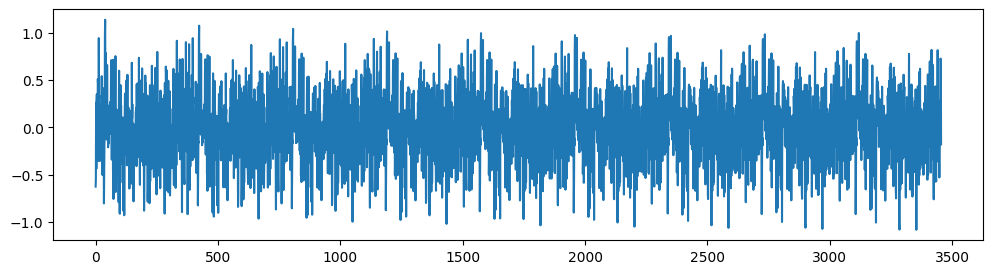

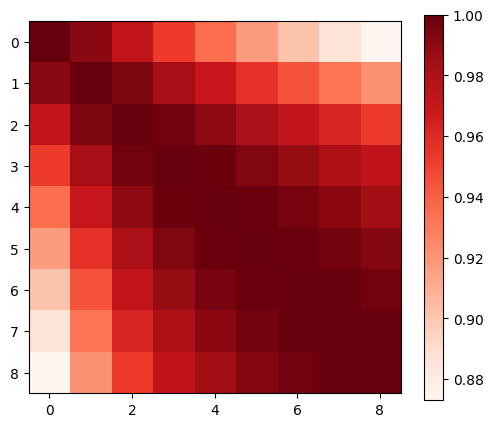

<Figure size 600x500 with 0 Axes>

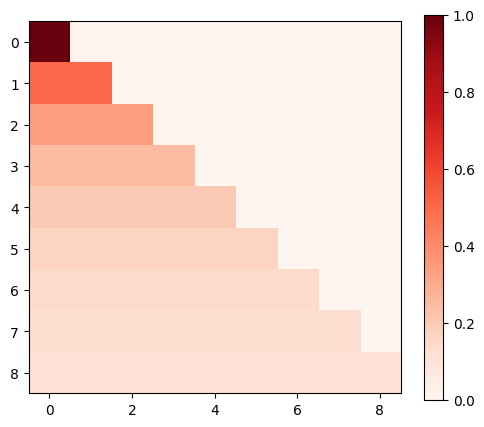

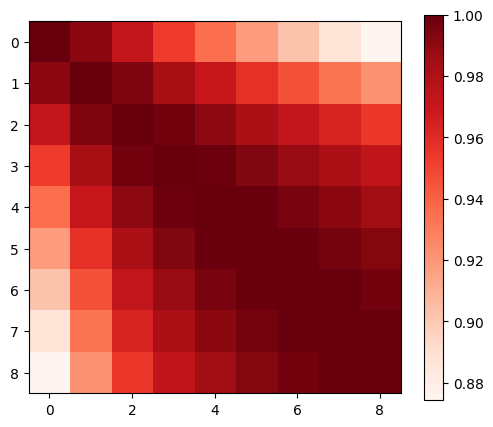

tensor(0.1111)


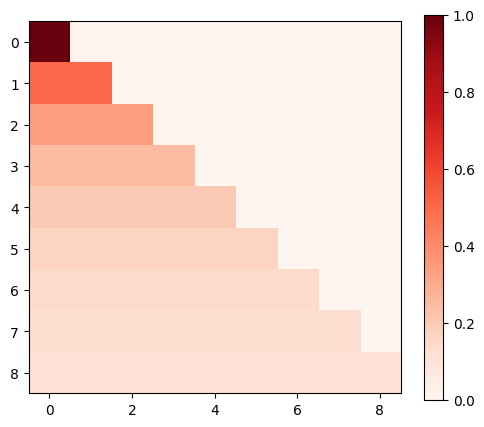

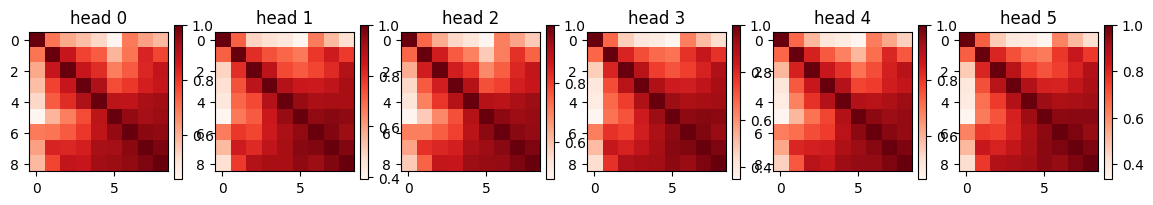

In [30]:
# the difference in projection for the same vector
# x = torch.rand(1, 1, 384).to(device)
n_embd = 384
x = torch.zeros(1, 1, n_embd).to(device)
sc = torch.rand(1, 1, n_embd).to(device)

idx = np.random.randint(0, n_embd)

x[0, 0, idx] = 1
x += sc
# y = model_list[17].transformer.h[1].attn.c_attn(x)
# input_idx = torch.tensor(encode('12modp(123)=')).to(device)[None,...]
input_idx = torch.tensor(encode('$123+456=')).to(device)[None,...]

# eqx = torch.tensor(model.create_equal_distancing_vecotrs(8, n_embd, small_component=0.1)[0]).to(device).to(torch.float32)[None,...] * 0.1

eqx = torch.tensor(model.create_equal_distancing_vecotrs(8, n_embd, small_component=0.0)[0]).to(device).to(torch.float32)[None,...] * 0.1


# cur_model = model_list[12]
cur_model = model_list[2]
# cur_model = model_list[24]


for level in range(len(cur_model.transformer.h)):
    activation = {}

    def getActivation(name):
        # the hook signature
        def hook(model, input, output):
            activation[name] = output.detach()

        return hook

    h1 = cur_model.transformer.h[level].attn.c_attn.register_forward_hook(
        getActivation(f"layer_{level}")
    )
    

    h2 = cur_model.transformer.h[level].attn.identity.register_forward_hook(
        getActivation(f"layer_{level}_iden")
    )

    with torch.no_grad():


        out = cur_model(input_idx)
        # decode and print out
        y = decode([out[0].detach().cpu().numpy().argmax()])
        # print(y)
        # _ = cur_model(eqx, direct_input_modification=True)
        # _ = cur_model(x, direct_input_modification=True)



    

    h1.remove()
    h2.remove()
    y = activation[f"layer_{level}"]

    q, k, v  = y.split(n_embd, dim=2)
    plt.figure(figsize=(12, 3))
    plt.plot(q.detach().cpu().numpy().flatten())
    plt.plot(k.detach().cpu().numpy().flatten()-1)
    plt.show()

    fig, ax = plt.subplots(1, cur_model.config.n_head, figsize=(14, 2))
    q_reshape = q.reshape(1, cur_model.config.n_head, -1, n_embd//cur_model.config.n_head)
    k_reshape = k.reshape(1, cur_model.config.n_head, -1, n_embd//cur_model.config.n_head)
    for i in range(cur_model.config.n_head):
        calc = (torch.nn.Softmax(dim=-1)(q_reshape[0, :, i, :]@k_reshape[0, :, i, :].transpose(0,1)))
        calc = torch.ones_like(calc) * calc.mean()
        result = calc.detach().cpu().numpy()

        mat = ax[i].imshow(result, cmap='Reds', interpolation='nearest')
        ax[i].set_title(f'head {i}')
        plt.colorbar(mat, ax=ax[i], orientation='vertical', fraction=0.06, pad=0.04,)
    plt.show()
        

    fig, ax = plt.subplots(1, 2, figsize=(5, 2))
    # plt.figure(figsize=(2, 5))
    # mat = ax[0].
    plt.imshow((torch.nn.Softmax(dim=-1)(q@k.transpose(1, 2))).detach().cpu().numpy()[0], cmap='Reds', interpolation='nearest')
    
    calc = torch.nn.Softmax(dim=-1)(q@k.transpose(1, 2))
    calc = torch.ones_like(calc) * calc.mean()
    result = calc.detach().cpu().numpy()
    mat = ax[0].imshow(result[0], cmap='Reds', interpolation='nearest')

    plt.colorbar(mat, ax=ax[0], orientation='vertical', fraction=0.06, pad=0.04,)

    # plt.colorbar()

    q_ = q.detach().cpu().numpy()[0]
    k_ = k.detach().cpu().numpy()[0]
    mat = cosine_similarity(q_, k_)

    mat = ax[1].imshow(mat, cmap='Reds', interpolation='nearest')
    plt.colorbar(mat, ax=ax[1], orientation='vertical', fraction=0.06, pad=0.04,)
    plt.show()


    print(x.sum(), q.abs().sum(), k.abs().sum(), v.abs().sum())

    y = activation[f"layer_{level}_iden"].detach().cpu().numpy()
    plt.figure(figsize=(12, 3))
    plt.plot(y.flatten())
    plt.show()

    plt.figure(figsize=(6, 5))
    mat = cosine_similarity(y[0], y[0])
    plt.imshow(mat, cmap='Reds', interpolation='nearest')
    plt.colorbar()
    
    plt.figure(figsize=(6, 5))
    
    # maskout the upper triangle
    calc = torch.nn.Softmax(dim=-1)(q@k.transpose(1, 2))
    calc = torch.ones_like(calc) * calc.mean()
    mask = np.triu(np.ones_like(calc[0].detach().cpu().numpy(), dtype=bool))[None, ...]
    mask = torch.tensor(mask).to(device)

    digit = calc[0, 0, 0].detach().cpu().clone()
    calc[mask] = -np.inf
    calc[0].diagonal().fill_(digit)
    calc = torch.nn.Softmax(dim=-1)(calc)

    plt.figure(figsize=(6, 5))
    plt.imshow(calc[0].detach().cpu().numpy(), cmap='Reds', interpolation='nearest')
    plt.colorbar()
    plt.show()

    y = calc.cpu() @ v.cpu()
    y = y.numpy()
    mat = cosine_similarity(y[0], y[0])
    plt.figure(figsize=(6, 5))
    plt.imshow(mat, cmap='Reds', interpolation='nearest')
    plt.colorbar()
    plt.show()


    calc = torch.nn.Softmax(dim=-1)(torch.einsum('bhid,bhjd->bhij', q_reshape, k_reshape))
    calc = torch.ones_like(calc) * calc.mean()
    mask = np.triu(np.ones_like(calc[0].detach().cpu().numpy(), dtype=bool))[None, ...]
    mask = torch.tensor(mask).to(device)

    digit = calc[0, 0, 0,0 ].detach().cpu().clone()
    print(digit)
    calc[mask] = -np.inf 
    # for i in range(calc.shape)
    #     calc[0, 0].diagonal().fill_(digit)
    T = calc.shape[-1]
    calc[:,:,np.arange(T),np.arange(T)] = digit
    calc = torch.nn.Softmax(dim=-1)(calc)

    plt.figure(figsize=(6, 5))
    plt.imshow(calc[0,0].detach().cpu().numpy(), cmap='Reds', interpolation='nearest')
    plt.colorbar()
    plt.show()

    v_reshape = v.reshape(1, cur_model.config.n_head, -1, n_embd//cur_model.config.n_head)
    y = calc.cpu() @ v_reshape.cpu()
    y = y.numpy()
    fig, ax = plt.subplots(1, cur_model.config.n_head, figsize=(14, 2))
    for i in range(cur_model.config.n_head):
        result = cosine_similarity(y[0, i], y[0, i])    
        mat = ax[i].imshow(result, cmap='Reds', interpolation='nearest')
        ax[i].set_title(f'head {i}')
        plt.colorbar(mat, ax=ax[i], orientation='vertical', fraction=0.06, pad=0.04,)
    plt.show()
    # raise ValueError

tensor([[[-0.8628]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)

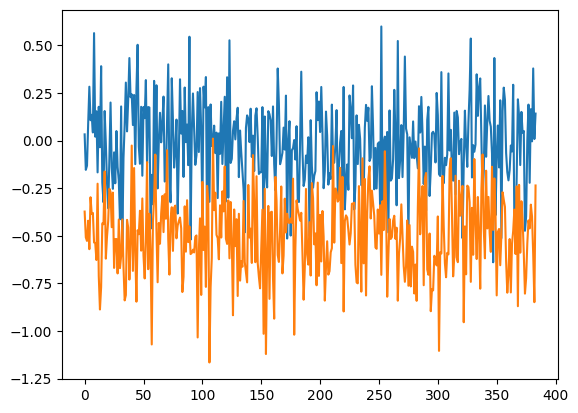

In [ ]:
plt.plot(q.detach().cpu().numpy().flatten())
plt.plot(k.detach().cpu().numpy().flatten()-0.5)

q@k.transpose(1, 2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
TH = 0.9
print((corr_mat >= TH).sum())
idxes = np.nonzero(corr_mat >= TH)
size = np.vstack(idxes).max()+1
sub_mat = np.zeros((size, size))
sub_mat[idxes] = 1


# Assuming you have calculated 'corr_mat' as described in the previous answer

# Create a heatmap of corr_mat
plt.figure(figsize=(4, 3), dpi=200)
plt.imshow(sub_mat, cmap='grey', interpolation='nearest')
# plt.colorbar(label=)

# Set axis labels and title
plt.xlabel('u2 Index')
plt.ylabel('u1 Index')
plt.title('Where Correlation Coefficient >= 0.9')
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.stats import pearsonr
# @widgets.interact(idx=(0, len(u1)-1), idx2=(0, len(u2)-1), continuous_update=True)


@widgets.interact(idx=(0, len(idxes[0])), save=[False, True], continuous_update=True,)
def show(idx, save=False):
    idx, idx2 = idxes[0][idx], idxes[1][idx]
    plt.figure(figsize=(4, 3), dpi=100)
    plt.scatter(u1[idx, :], u2[idx2, :], alpha=0.5)
    print(pearsonr(u1[idx, :], u2[idx2, :])[0])
    divisor = len(u1)//fixed_length
    r1, c1 = idx//divisor, idx % divisor
    r2, c2 = idx2//divisor, idx2 % divisor
    plt.title(
    f"U1[{r1, c1}] vs U2[{r2, c2}] (corr={pearsonr(u1[idx, :], u2[idx2, :])[0]:.3f})")
    # plt.show()
    if save:
        os.makedirs(f'./saved_plots/{u1_name}_VS_{u2_name}/', exist_ok=True)
        plt.savefig(
            f'./saved_plots/{u1_name}_VS_{u2_name}/U1[{idx}]_vs_U2[{idx2}].svg')
    plt.show()
    # return

## Weight distributuion

### EXP

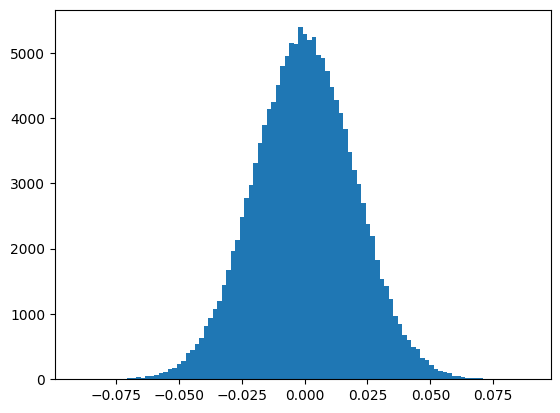

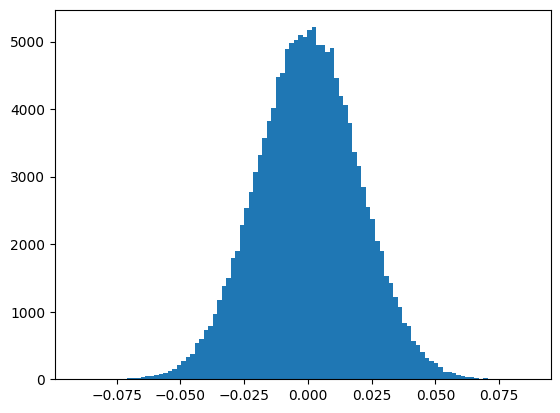

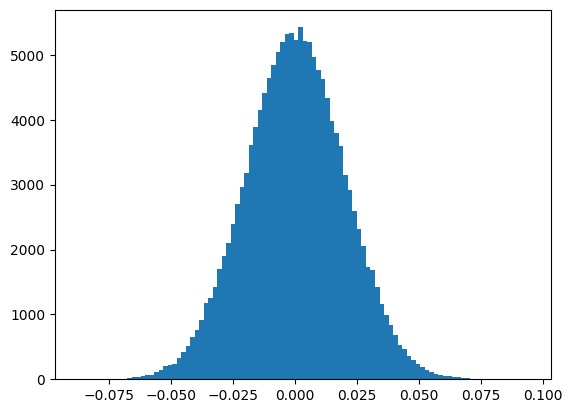

In [114]:
kqv_weights = model.transformer.h[0].attn.c_attn.weight.detach().cpu().numpy()
q_weights = kqv_weights[:kqv_weights.shape[0]//3]
k_weights = kqv_weights[kqv_weights.shape[0]//3:2*kqv_weights.shape[0]//3]
v_weights = kqv_weights[2*kqv_weights.shape[0]//3:]
import matplotlib.pyplot as plt
plt.hist(k_weights.flatten(), bins=100)
plt.show()
plt.hist(v_weights.flatten(), bins=100)
plt.show()
plt.hist(q_weights.flatten(), bins=100)
plt.show()

In [116]:
vecs, dists = GPT_nope.create_equal_distancing_vecotrs(12, 384,)
dists[5]

array([0.99884793, 0.99884793, 0.99884793, 0.99884793, 0.99884793,
       1.        , 0.99884793, 0.99884793, 0.99884793, 0.99884793,
       0.99884793, 0.99884793])

In [86]:
vecs.shape

(12, 384)

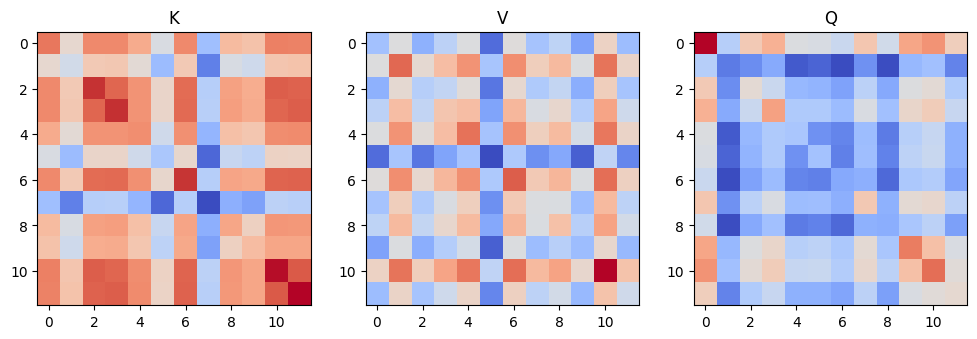

In [117]:
kvecs = vecs@k_weights
kdists = kvecs@kvecs.T
vvecs = vecs@v_weights
vdists = vvecs@vvecs.T
qvecs = vecs@q_weights
qdists = qvecs@qvecs.T
# subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(kdists, cmap='coolwarm', interpolation='nearest')
axs[0].set_title('K')
axs[1].imshow(vdists, cmap='coolwarm', interpolation='nearest')
axs[1].set_title('V')
axs[2].imshow(qdists, cmap='coolwarm', interpolation='nearest')
axs[2].set_title('Q')
plt.show()


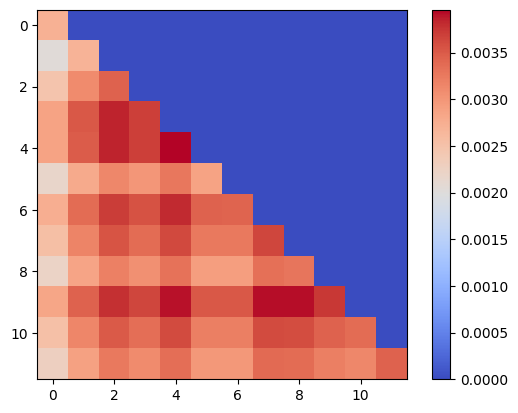

In [118]:
T = kdists.shape[0]
bias = torch.tril(torch.ones(T, T)).numpy()
kvmap = qvecs@kvecs.T
kvmap_causal = kvmap.copy()
kvmap_causal[bias==0] = 0

plt.imshow(kvmap_causal, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

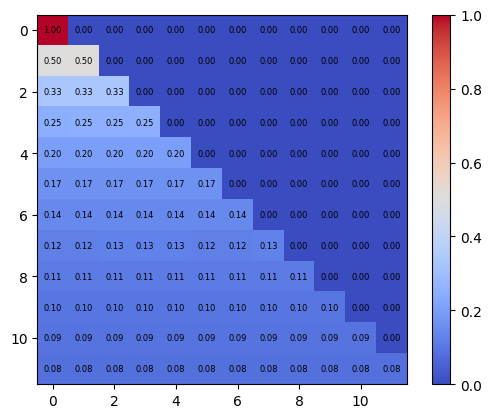

In [119]:
kvmap_softmax = kvmap.copy()
kvmap_softmax[bias==0] = -np.inf
kvmap_softmax = np.exp(kvmap_softmax)
kvmap_softmax /= kvmap_softmax.sum(axis=1, keepdims=True)
plt.imshow(kvmap_softmax, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
for i in range(kvmap_softmax.shape[0]):
    for j in range(kvmap_softmax.shape[1]):
        plt.text(j, i, f'{kvmap_softmax[i, j]:.02f}', ha='center', va='center', color='black', fontsize=6)
plt.show()

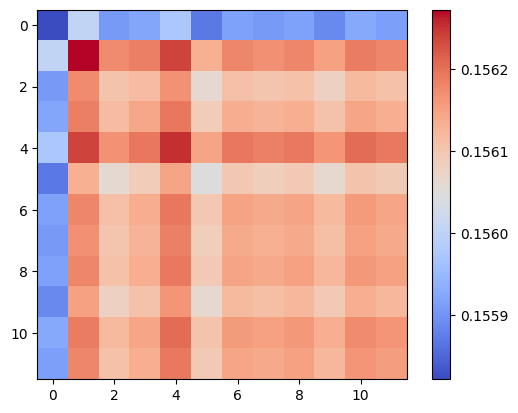

In [120]:
att_out = kvmap_softmax@vvecs
self_dot_prod = att_out@att_out.T
plt.imshow(self_dot_prod, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

### THEORY

In [47]:
from sympy import symbols, simplify

# Define symbols
m, n = symbols('m n')

# Given values for dot products
v1_v1 = v2_v2 = v3_v3 = n
v1_v2 = v1_v3 = v2_v3 = m

# z.x
zx = (1/4)*v1_v1 + (1/4)*v1_v2 + (1/2)*v1_v3
# z.y
zy = (1/4)*(1/3)*v1_v1 + (1/4)*(2/3)*v1_v2 + (1/4)*(1/3)*v1_v2 + (1/4)*(2/3)*v2_v2 + (1/2)*(1/3)*v1_v3 + (1/2)*(2/3)*v2_v3
# z.zz
zz = (1/4)**2*v1_v1 + 2*(1/4)**2*v1_v2 + (1/2)**2*v1_v3 + (1/4)**2*v2_v2 + 2*(1/4)*(1/2)*v2_v3 + (1/2)**2*v3_v3

# Simplify expressions
zx_simplified = simplify(zx)
zy_simplified = simplify(zy)
zz_simplified = simplify(zz)

zx_simplified, zy_simplified, zz_simplified

(0.75*m + 0.25*n, 0.75*m + 0.25*n, 0.625*m + 0.375*n)

In [51]:
from sympy import exp, simplify

# Define e as the base of the natural logarithm
# e = exp(1)
e = 2.718281828459045

# Calculate a1, a2, b1, b2, b3
a1 = e**(1/2) / (e**(1/2) + e**1)
a2 = 1 - a1
b1 = b2 = e**(1/2) / (e**(1/2) + e**(1/2) + e**1)
b3 = 1 - b1 - b2

# Define symbols
m, n = symbols('m n')

# Given values for dot products
v1_v1 = v2_v2 = v3_v3 = n
v1_v2 = v1_v3 = v2_v3 = m

# z.x
zx = b1*v1_v1 + b2*v1_v2 + b3*v1_v3
# z.y
zy = (b1*a1 + b2*a2)*v1_v1 + (b1*a2)*v1_v2 + (b2*a1)*v1_v2 + (b2*a2)*v2_v2 + b3*a1*v1_v3 + b3*a2*v2_v3
# z.z
zz = (b1**2 + b2**2)*v1_v1 + 2*(b1*b2)*v1_v2 + 2*(b1*b3 + b2*b3)*v1_v3 + b3**2*v3_v3 + (b2**2)*v2_v2 + 2*(b2*b3)*v2_v3

# Simplify expressions
a1_val, a2_val, b1_val, b2_val, b3_val = [simplify(val) for val in [a1, a2, b1, b2, b3]]
zx_simplified = simplify(zx.subs({v1_v1: n, v1_v2: m, v1_v3: m}))
zy_simplified = simplify(zy.subs({v1_v1: n, v1_v2: m, v1_v3: m, v2_v2: n, v2_v3: m}))
zz_simplified = simplify(zz.subs({v1_v1: n, v1_v2: m, v1_v3: m, v2_v2: n, v2_v3: m, v3_v3: n}))

a1_val, a2_val, b1_val, b2_val, b3_val, zx_simplified, zy_simplified, zz_simplified

(0.377540668798145,
 0.622459331201855,
 0.274068619061197,
 0.274068619061197,
 0.451862761877606,
 0.725931380938803*m + 0.274068619061197*n,
 0.725931380938803*m + 0.444665188385446*n,
 0.893275634826067*m + 0.429520779433993*n)

In [55]:
m_value = 1
n_value = 2  # Example values where n > m

# Evaluate zx, zy, zz with substituted values of m and n
zx_value = zx_simplified.subs({m: m_value, n: n_value,})
zy_value = zy_simplified.subs({m: m_value, n: n_value,})
zz_value = zz_simplified.subs({m: m_value, n: n_value,})

zx_value, zy_value, zz_value

(1.27406861906120, 1.61526175770969, 1.75231719369405)

## PCA visualizaiton

In [16]:
# prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
import glob
from IPython.utils import io


input_act1_list = []
# for config_dir, model_config_fold in exp_list:
#   with open(f'{config_dir}/{model_config_fold}/config.yaml') as f:
#     config_dict = yaml.load(f, Loader=yaml.FullLoader)
#   ckpt = f"{config_dir}/ckpt_10000_final.pt"
#   model = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda')

for config_dir, model_config_fold in exp_list:
    glob_dir = config_dir.replace('[', '*').replace(']', '*')
    yaml_path = glob.glob(f'{glob_dir}/**/config.yaml')[0]
    config_dir = '/'.join(yaml_path.split('/')[:-2])
    with open(yaml_path) as f:
        config_dict = yaml.load(f, Loader=yaml.FullLoader)
    # ckpt = glob.glob(f"{config_dir}/ckpt_**_acc.pt", recursive=True)[0]
    # ckpt = glob.glob(f'{glob_dir}/ckpt_**_acc.pt')[0]
    ckpt = glob.glob(f'{glob_dir}/ckpt_**.pt')[0]

    with io.capture_output() as captured:
        # model, gptconfig = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda', return_config=True)
        model, gptconfig = load_checkpoint(
            ckpt, GPTConfig_nope, GPT_nope, device='cuda', return_config=True)
        # gptconfig.use_pe = 'sin'
        # model = GPT_nope(gptconfig)

    cur_input_act1_list = []
    # for i in range(0, 3):
    # model.transformer.h[0].permute = False
    # prompts = [
    #   f"${823}" + '+' + f"{8}"*3 + '=',
    #   f"${238}" + '+' + f"{8}"*3 + '='
    # ]
    zs = np.zeros(12).astype(np.int64)
    n_1s = 3
    zs[np.random.permutation(12)[:n_1s]] = 1
    str_zs = ''.join(map(str, zs))

    prompts = [
        # f'\nparity({str_zs})=',
        # '\nparity(100101010000)='
        # '\nparity(010101000101)='
        # 'parity(000010101001)=',
        # '    $331+=',
        'paridy(110001101010)=',
        # '123+456'
    ]
    # prompts = [
    #   f"${623}" + '+' + f"{5}"*3 + '=',
    #   f"${632}" + '+' + f"{5}"*3 + '='
    # ]
    for i in range(0, 1):  # try 10 batches

        # prompt = "$" + f"{i}"*3 + f"{i}"*6
        # prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
        # prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
        prompt = prompts[i]

        activation = {}

        def getActivation(name):
            # the hook signature
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook
        # register forward hooks on the layers of choice
        h1 = model.transformer.h[1].register_forward_hook(
            getActivation('layer_1'))
        h2 = model.transformer.ln_f.register_forward_hook(
            getActivation('x_out'))
        # out_text = generate_output(model, prompt, max_new_tokens=5)
        out_text = generate_output(model, prompt, max_new_tokens=4,)

        h1.remove()
        h2.remove()
        model_name = config_dir.split('/')[-1]
        print(model_name)
        PCA_analysis(prompt, activation['x_out'][0], out_text, config_dir)

paridy_nc_sd240_T2403262154_nope_res=[2, 3, 4, 5]_ncTrue


paridy(110001101010)=0100
[0.99651134 0.00236212]


In [17]:
def paridy(x):
    x_trunc = str(x)
    start_1 = x_trunc.find('1')
    end_1 = x_trunc.rfind('1')
    y_trunc = x_trunc[start_1:end_1+1].count('0') % 2
    return y_trunc


paridy(110001101010)

1

In [23]:
from threading import main_thread
import main_utils
# start_train = None
reverse_ab = False
reverse_c = True
zero_pad = False
algo_reason = False
add_space = False
config['causal_training'] = True



config['start'] = start

model, gptconfig = load_checkpoint(
                "./outputs_permute/add3_remove_8_nope_residual_exp/add3_remove_8_sd240_T2405280721_nope_lwpTrue_pmremove00000/ckpt_10000_acc_5000.pt",
                GPTConfig_nope,
                GPT_nope,
                device="cuda" if torch.cuda.is_available() else "cpu",
                return_config=True,
                init=False,
                init_additional_config={},
)
model.to(device)
model.eval()


main_utils.evaluate_addition_batch(config, model, ctx, encode, decode, verbose=True, num_digit=num_digit, zero_pad=zero_pad,
                                   reverse_ab=reverse_ab, reverse_c=reverse_c, algo_reason=algo_reason,
                                   binary=binary, data_type=data_type, operator=operator, data_format=data_format)

Using Flash Attention
Block 0: 1.0 | att_res True | perm remove | mlp_res True | layerwise_pe 0 | casual True
Using Flash Attention
Block 1: 1.0 | att_res True | perm 0 | mlp_res True | layerwise_pe 0 | casual True
Using Flash Attention
Block 2: 1.0 | att_res True | perm 0 | mlp_res True | layerwise_pe 0 | casual True
Using Flash Attention
Block 3: 1.0 | att_res True | perm 0 | mlp_res True | layerwise_pe 0 | casual True
Using Flash Attention
Block 4: 1.0 | att_res True | perm 0 | mlp_res True | layerwise_pe 0 | casual True
Using Flash Attention
Block 5: 1.0 | att_res True | perm 0 | mlp_res True | layerwise_pe 0 | casual True
PE in use: nope
number of parameters: 10.66M
test_run
0 
1 
2 
3 
4 
5 
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(96, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
  

 92%|█████████▎| 74/80 [00:01<00:00, 57.75it/s]

outputs(x):  $75+625=0041$

wrong  : 75+625=1400
correct: 75+625=700
outputs(x):  $59+149=807$
$
wrong  : 59+149=708
correct: 59+149=208
outputs(x):  $81+965=6481$

wrong  : 81+965=1846
correct: 81+965=1046
outputs(x):  $59+706=5621$

wrong  : 59+706=1265
correct: 59+706=765
outputs(x):  $39+797=6311$

wrong  : 39+797=1136
correct: 39+797=836
outputs(x):  $28+515=347$
$
wrong  : 28+515=743
correct: 28+515=543
outputs(x):  $81+740=1261$

wrong  : 81+740=1621
correct: 81+740=821
outputs(x):  $73+963=6371$

wrong  : 73+963=1736
correct: 73+963=1036
outputs(x):  $30+130=064$
$
wrong  : 30+130=460
correct: 30+130=160
outputs(x):  $68+685=3531$

wrong  : 68+685=1353
correct: 68+685=753
outputs(x):  $50+745=5921$

wrong  : 50+745=1295
correct: 50+745=795
outputs(x):  $75+695=0741$

wrong  : 75+695=1470
correct: 75+695=770
outputs(x):  $63+660=3231$

wrong  : 63+660=1323
correct: 63+660=723
outputs(x):  $60+258=819$
$
wrong  : 60+258=918
correct: 60+258=318
outputs(x):  $86+780=6661$

wrong  :

100%|██████████| 80/80 [00:01<00:00, 48.85it/s]

outputs(x):  $66+576=247$

wrong  : 66+576=742
correct: 66+576=642
outputs(x):  $21+562=387$

wrong  : 21+562=783
correct: 21+562=583
outputs(x):  $53+674=7221$
wrong  : 53+674=1227
correct: 53+674=727
outputs(x):  $9+162=181$
$
wrong  : 9+162=181
correct: 9+162=171
outputs(x):  $3+323=653$
$
wrong  : 3+323=356
correct: 3+323=326
outputs(x):  $4+829=339$
$
wrong  : 4+829=933
correct: 4+829=833
outputs(x):  $9+750=958$
$
wrong  : 9+750=859
correct: 9+750=759
outputs(x):  $7+975=2501$

wrong  : 7+975=1052
correct: 7+975=982
outputs(x):  $3+442=574$
$
wrong  : 3+442=475
correct: 3+442=445
outputs(x):  $4+294=823$
$
wrong  : 4+294=328
correct: 4+294=298
outputs(x):  $9+219=823$
$
wrong  : 9+219=328
correct: 9+219=228
outputs(x):  $6+631=796$
$
wrong  : 6+631=697
correct: 6+631=637
outputs(x):  $3+635=886$
$
wrong  : 3+635=688
correct: 3+635=638
outputs(x):  $1+116=721$
$
wrong  : 1+116=127
correct: 1+116=117
outputs(x):  $3+849=239$
$
wrong  : 3+849=932
correct: 3+849=852
outputs(x):  $9+5

(95.75757575757575,
 {'carry0': 94.30379746835443,
  'carry1': 94.69466703509258,
  'carry2': 96.09120521172639,
  'carry3': 99.54682779456193,
  'carry4': nan,
  'carry5': nan})

interesting: for a causal model with pe, with or without "\n" makes a 180 degree difference in outcome !!!!!

## Original_model_pe_PCA

In [104]:
x = model.transformer.wpe.weight.cpu().detach().numpy()
x.shape

(256, 384)

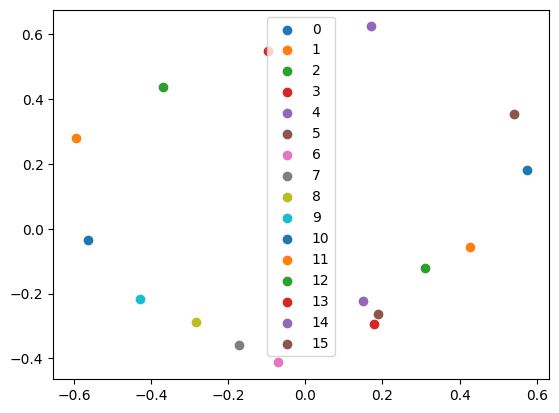

[[ 0.57404906  0.18091261]
 [ 0.42592266 -0.0552854 ]
 [ 0.3105009  -0.12041674]
 [ 0.17746264 -0.29408967]
 [ 0.14986224 -0.22194865]
 [ 0.18950118 -0.26214504]
 [-0.07151226 -0.41235036]
 [-0.1722473  -0.35763952]
 [-0.28476417 -0.28858176]
 [-0.42833287 -0.21658199]
 [-0.5626896  -0.03320071]
 [-0.59554493  0.28155863]
 [-0.36853096  0.43710715]
 [-0.0961227   0.54890597]
 [ 0.17018779  0.6244606 ]
 [ 0.5404304   0.352905  ]]
[0.12837423 0.11656444]


In [105]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
x = model.transformer.wpe.weight.cpu().detach().numpy()
# select sample maybe from test set
# but if, different digits seems to be encoded the same way, than it has a patter
pca = PCA(n_components=2)
new_x = pca.fit_transform(x)
new_x = new_x[::16]
for text, pt in zip(range(len(new_x)), new_x, ):
    plt.scatter(pt[0], pt[1], label=text)

plt.legend()
plt.show()
print(new_x)
print(pca.explained_variance_ratio_)

## Probing

In [14]:
from re import U
import ipywidgets as widgets

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

sim_measure = lambda u1, u2: np.dot(u1, u2.T)
# sim_measure = cosine_similarity


def standardize_rows(matrix):
    """Standardize each row of the matrix."""
    mean = matrix.mean(axis=1, keepdims=True)
    std = matrix.std(axis=1, keepdims=True)
    return (matrix - mean) / std


def plot_corr_mat(corr_mat, vec_dim, is_corr=True, absval=True):

    show_text = False if not is_corr else True

    # Create a heatmap of corr_mat
    plt.figure(figsize=(6, 5), dpi=120)
    # plt.imshow(corr_mat, cmap='seismic', interpolation='nearest')
    plt.imshow(corr_mat, cmap="coolwarm", interpolation="nearest")

    extra_text = "Absolute" if is_corr else ""
    plot_type = f"{extra_text} Correlation Coefficient" if is_corr else "Dot Product"

    plt.colorbar(
        label=plot_type,
        # fraction=0.01,
        # pad=0.04,
    )
    if show_text:
        for i in range(0, len(corr_mat), vec_dim):
            for j in range(0, len(corr_mat), vec_dim):
                plt.text(
                    j + vec_dim // 2,
                    i + vec_dim // 2,
                    f"{corr_mat[i:i+vec_dim, j:j+vec_dim].sum():.02f}",
                    ha="center",
                    va="center",
                    color="black",
                )


level_corr_mat_accum = []
corr_mat = None
u1, u2, u1_name, u2_name = None, None, None, None

task_name = "mod_"
folder_name = f"corr_{task_name}" if not equal_distancing_exp else f"dot_{task_name}"
folder_name += "_trained" if not model_init else "_init"


@widgets.interact(
    idx1=(0, len(input_act1_list) - 1), idx2=(0, len(input_act1_list) - 1), level=(0, 5)
)
def get_corr(
    idx1,
    level=0,
    save=False,
    absval=True,
    save_all=False,
    accumulate_all=False,
    is_rand_init=False,
    subplot_layers=False,
):
    global corr_mat
    global u1, u2, u1_name, u2_name
    rand_state = "init_" if is_rand_init else ""
    if not (save_all or accumulate_all):
        if not subplot_layers:
            idx2 = idx1
            input_act1_list = all_level_input_act_list[level]
            u1, u2 = input_act1_list[idx1], input_act1_list[idx2]

            u1 = u1.T
            u2 = u2.T
            print(exp_list[idx1][0].split("sd")[-1], exp_list[idx2][0].split("sd")[-1])
            print(u2.shape)

            is_corr = False
            if u2.shape[1] != 1:
                # Standardize each row of u1 and u2
                u1_standardized = standardize_rows(u1)
                u2_standardized = standardize_rows(u2)
                # u1_standardized = u1
                # u2_standardized = u2

                # Compute the correlation matrix
                corr_mat = np.dot(u1_standardized, u2_standardized.T) / (u1.shape[1])
            else:
                u1 = u1.reshape(-1, 384)
                u2 = u2.reshape(-1, 384)
                # corr_mat = np.dot(u1, u2.T)
                corr_mat = sim_measure(u1, u2)

            if absval:
                corr_mat = np.abs(corr_mat)
            else:
                pass
            vec_dim = corr_mat.shape[0] // 8
            total_sum = np.abs(corr_mat).sum()
            block_sum = 0
            for i in range(0, len(corr_mat), vec_dim):
                block_sum += np.abs(corr_mat[i : i + vec_dim, i : i + vec_dim]).sum()
            ratio = block_sum / (total_sum - block_sum)

            plot_corr_mat(corr_mat, vec_dim, is_corr=is_corr, absval=absval)

            nope2 = "nope_" if "nope" in exp_list[idx1][1] else ""
            u2_name = "_".join(exp_list[idx2][1].split("_")[2:])
            u2_name = (
                nope2 + u2_name.split("_")[-1] + "_" + "_".join(u2_name.split("_")[:-1])
            )

            if save:
                os.makedirs(f"./saved_plots_{folder_name}/", exist_ok=True)
                plt.savefig(
                    f"./saved_plots_{folder_name}/{task_name+folder_name}_{rand_state}_{u2_name}_layer{level}_{ratio:.03f}_{abs}.svg"
                )

            # close img
            # plt.close()
            plt.show()
        else:
            fig, axs = plt.subplots(
                1, 6, figsize=(36, 5)
            )  # 6 subplots in a row, adjust size as needed

            global_min, global_max = float("inf"), float("-inf")
            corr_mat_list = []
            for level in range(6):
                idx2 = idx1
                input_act1_list = all_level_input_act_list[level]
                u1, u2 = input_act1_list[idx1], input_act1_list[idx2]

                u1 = u1.T
                u2 = u2.T

                if u2.shape[1] != 1:
                    u1_standardized = standardize_rows(u1)
                    u2_standardized = standardize_rows(u2)
                    corr_mat = np.dot(u1_standardized, u2_standardized.T) / (
                        u1.shape[1]
                    )
                else:
                    u1 = u1.reshape(-1, 384)
                    u2 = u2.reshape(-1, 384)
                    # corr_mat = np.dot(u1, u2.T)
                    corr_mat = sim_measure(u1, u2)

                if absval:
                    corr_mat = np.abs(corr_mat)
                corr_mat_list.append(corr_mat)

                global_min = min(global_min, corr_mat.min())
                global_max = max(global_max, corr_mat.max())

            for level in range(6):

                corr_mat = corr_mat_list[level]

                # vec_dim = 384
                vec_dim = corr_mat.shape[0] // fixed_length

                total_sum = np.abs(corr_mat).sum()
                block_sum = 0
                for i in range(0, len(corr_mat), vec_dim):
                    block_sum += np.abs(
                        corr_mat[i : i + vec_dim, i : i + vec_dim]
                    ).sum()
                ratio = block_sum / (total_sum - block_sum)

                cm = axs[level].imshow(
                    corr_mat, cmap="coolwarm", interpolation="nearest"
                )
                #   , vmin=global_min, vmax=global_max)
                axs[level].set_title(f"Layer {level}")
                plt.colorbar(
                    cm,
                    ax=axs[level],
                    orientation="vertical",
                    fraction=0.06,
                    pad=0.04,
                )

            extra_text = "Absolute " if absval else ""
            # fig.colorbar(cbar_ax, ax=axs, orientation='vertical', label=f'{extra_text}Correlation Coefficient')

            # Set axis labels and title
            # plt.xlabel('U2 Entries')
            # plt.ylabel('U1 Entries')

            # Show the plot
            nope1 = "nope_" if "nope" in exp_list[idx1][1] else ""
            u1_name = "_".join(exp_list[idx1][1].split("_")[2:])
            u1_name = (
                nope1 + u1_name.split("_")[-1] + "_" + "_".join(u1_name.split("_")[:-1])
            )
            nope2 = "nope_" if "nope" in exp_list[idx1][1] else ""
            u2_name = "_".join(exp_list[idx2][1].split("_")[2:])
            u2_name = (
                nope2 + u2_name.split("_")[-1] + "_" + "_".join(u2_name.split("_")[:-1])
            )

            extra_self = "Self" if u1_name == u2_name else ""
            # plt.title(f'{extra_self} Correlation Matrix for  {ratio:.2f}')
            print(u2_name)
            if save:
                os.makedirs(f"./saved_plots_{folder_name}/", exist_ok=True)
                plt.savefig(
                    f"./saved_plots_{folder_name}/{task_name+folder_name}_{len(all_level_input_act_list)}layers_{rand_state}_{u2_name}_{ratio:.03f}_{abs}.svg"
                )

            # close img
            # plt.close()
            plt.show()

    else:
        corr_mat_list = []
        for level in range(len(all_level_input_act_list)):
            input_act1_list = all_level_input_act_list[level]
            global level_corr_mat_accum
            for idx1 in tqdm(range(len(input_act1_list))):
                idx2 = idx1
                u1, u2 = input_act1_list[idx1], input_act1_list[idx2]
                u1 = u1.T
                u2 = u2.T

                if u2.shape[1] != 1: # calculate correlation coefficient
                    u1_standardized = standardize_rows(u1)
                    u2_standardized = standardize_rows(u2)
                    # u1_standardized = u1
                    # u2_standardized = u2

                    # Compute the correlation matrix
                    corr_mat = np.dot(u1_standardized, u2_standardized.T) / (
                        u1.shape[1]
                    )
                else:
                    u1 = u1.reshape(-1, 384)
                    u2 = u2.reshape(-1, 384)
                    # corr_mat = np.dot(u1, u2.T)
                    corr_mat = sim_measure(u1, u2)

                if absval:
                    corr_mat = np.abs(corr_mat)
                else:
                    pass

                if accumulate_all:
                    level_corr_mat_accum.append(corr_mat[None, ...])
                if not save_all:
                    continue

                if not subplot_layers:
                    vec_dim = corr_mat.shape[0] // 8
                    total_sum = np.abs(corr_mat).sum()
                    block_sum = 0
                    for i in range(0, len(corr_mat), vec_dim):
                        block_sum += np.abs(
                            corr_mat[i : i + vec_dim, i : i + vec_dim]
                        ).sum()
                    ratio = block_sum / (total_sum - block_sum)

                    # Assuming you have calculated 'corr_mat' as described in the previous answer

                    # Create a heatmap of corr_mat
                    plt.figure(figsize=(6, 5), dpi=120)
                    # plt.imshow(corr_mat, cmap='seismic', interpolation='nearest')
                    plt.imshow(corr_mat, cmap="coolwarm", interpolation="nearest")

                    extra_text = "Absolute " if absval else ""
                    plt.colorbar(label=f"{extra_text}Correlation Coefficient")

                    # Set axis labels and title
                    # plt.xlabel('U2 Entries')
                    # plt.ylabel('U1 Entries')

                    # Show the plot
                    nope1 = "nope_" if "nope" in exp_list[idx1][1] else ""
                    u1_name = "_".join(exp_list[idx1][1].split("_")[2:])
                    u1_name = (
                        nope1
                        + u1_name.split("_")[-1]
                        + "_"
                        + "_".join(u1_name.split("_")[:-1])
                    )
                    nope2 = "nope_" if "nope" in exp_list[idx1][1] else ""
                    u2_name = "_".join(exp_list[idx2][1].split("_")[2:])
                    u2_name = (
                        nope2
                        + u2_name.split("_")[-1]
                        + "_"
                        + "_".join(u2_name.split("_")[:-1])
                    )

                    extra_self = "Self" if u1_name == u2_name else ""
                    # plt.title(f'{extra_self} Correlation Matrix for  {ratio:.2f}')
                    # print(ratio)
                    # print(u1_name, u2_name)
                    os.makedirs(f"./saved_plots_{folder_name}/", exist_ok=True)
                    plt.savefig(
                        f"./saved_plots_{folder_name}/{task_name+folder_name}_{rand_state}_{u2_name}_layer{level}_{ratio:.03f}_{abs}.svg"
                    )

                    # close img
                    plt.close()
                # plt.show()

            if accumulate_all:
                level_corr_mat_accum = np.vstack(level_corr_mat_accum)
                print(level_corr_mat_accum.shape)
                level_corr_mat_accum = level_corr_mat_accum.mean(axis=0)
                # Create a heatmap of corr_mat
                if not subplot_layers:
                    plt.figure(figsize=(6, 5), dpi=120)
                    # plt.imshow(corr_mat, cmap='seismic', interpolation='nearest')
                    plt.imshow(
                        level_corr_mat_accum, cmap="coolwarm", interpolation="nearest"
                    )

                    extra_text = "Absolute " if absval else ""
                    plt.colorbar(label=f"{extra_text}Correlation Coefficient")
                    plt.show()
                corr_mat = level_corr_mat_accum
                level_corr_mat_accum = []
            corr_mat_list.append(corr_mat)
        if subplot_layers:
            fig, axs = plt.subplots(
                1, 6, figsize=(36, 5)
            )  # 6 subplots in a row, adjust size as needed
            for level in range(len(all_level_input_act_list)):

                corr_mat = corr_mat_list[level]

                # vec_dim = 384
                vec_dim = corr_mat.shape[0] // 8

                total_sum = np.abs(corr_mat).sum()
                block_sum = 0
                for i in range(0, len(corr_mat), vec_dim):
                    block_sum += np.abs(
                        corr_mat[i : i + vec_dim, i : i + vec_dim]
                    ).sum()
                ratio = block_sum / (total_sum - block_sum)

                cm = axs[level].imshow(
                    corr_mat, cmap="coolwarm", interpolation="nearest"
                )
                #   , vmin=global_min, vmax=global_max)
                axs[level].set_title(f"Layer {level}")
                plt.colorbar(
                    cm,
                    ax=axs[level],
                    orientation="vertical",
                    fraction=0.06,
                    pad=0.04,
                )

            print(u2_name)
            if save:
                os.makedirs(f"./saved_plots_{folder_name}/", exist_ok=True)
                plt.savefig(
                    f"./saved_plots_{folder_name}/{task_name+folder_name}_avg_{abs}.svg"
                )

            plt.show()

interactive(children=(IntSlider(value=12, description='idx1', max=24), IntSlider(value=0, description='level',…

In [40]:
exp_list

[['./outputs/residual_exp/addition_reverse_sd111_T2402040225_res=[0, 1, 2, 3, 4, 5]',
  'addition_reverse_sd111_T2402040225_res=[0, 1, 2, 3, 4, 5]'],
 ['./outputs/residual_exp/addition_reverse_sd555_T2402030324_res=[1, 2, 3, 4, 5]',
  'addition_reverse_sd555_T2402030324_res=[1, 2, 3, 4, 5]'],
 ['./outputs/residual_exp/addition_reverse_sd555_T2402030428_res=[0, 1, 2, 4, 5]',
  'addition_reverse_sd555_T2402030428_res=[0, 1, 2, 4, 5]'],
 ['./outputs/residual_exp/addition_reverse_sd555_T2402021605_res=[2, 3, 4, 5]',
  'addition_reverse_sd555_T2402021605_res=[2, 3, 4, 5]'],
 ['./outputs/nope_residual_exp/addition_reverse_sd111_T2402040212_nope_res=[0, 1, 2, 3, 4, 5]',
  'addition_reverse_sd111_T2402040212_nope_res=[0, 1, 2, 3, 4, 5]'],
 ['./outputs/nope_residual_exp/addition_reverse_sd555_T2402020708_nope_res=[1, 2, 3, 4, 5]',
  'addition_reverse_sd555_T2402020708_nope_res=[1, 2, 3, 4, 5]'],
 ['./outputs/nope_residual_exp/addition_reverse_sd555_T2402020708_nope_res=[1, 2, 3, 4, 5]',
  'addi

In [17]:
# prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
import glob
fixed_length = 8
sample_num = 1024
all_level_input_act_list = []

model_list = []
for idx, (config_dir, model_config_fold) in enumerate(exp_list):
    glob_dir = config_dir.replace('[', '[[]')
    yaml_path = glob.glob(f'{glob_dir}/**/config.yaml')[0]
    revised_glob_dir = '/'.join(yaml_path.split('/')[:-2])
    exp_list[idx][0] = revised_glob_dir
    exp_list[idx][1] = revised_glob_dir.split('/')[-1]

    with open(yaml_path) as f:
        config_dict = yaml.load(f, Loader=yaml.FullLoader)
    ckpt = f"{revised_glob_dir}/ckpt_10000_acc.pt"
    model, gptconfig = load_checkpoint(
        ckpt, GPTConfig_nope, GPT_nope, device='cuda', return_config=True)

    # gptconfig.not_causal = [1]*6
    # model = GPT_nope(GPTConfig_nope())
    # model = GPT_nope(gptconfig)

    # for i in range(len(model.transformer.h)):
    #   model.transformer.h[i].attn._reset_parameters()
    #   model.transformer.h[i].mlp._reset_parameters()
    # model.apply(model._init_weights)

    model.eval()
    model.to(device)
    model_list.append(model)


for level in range(0, 8):
    level = level - 1
    input_act1_list = [list() for _ in range(len(model_list))]

    for i in range(0, 1):  # try 5 batches
        X, Y = get_batch('train')
        X = decode(X[0].tolist())
        X_8 = list(map(lambda x: x[:fixed_length], filter(lambda x: len(
            x) >= fixed_length and x[fixed_length-1] == '=', X.split('\n'))))
        X_8 = [''.join(list(np.array(list(x))[np.random.permutation(len(x))]))
               for x in X_8]
        X = torch.tensor(list(map(lambda x: encode(x), X_8)))
        # X = X.reshape(-1, fixed_length)
        # X = X[:sample_num]
        X = X.to(device)

        for midx, model in enumerate(model_list):
            activation = {}

            def getActivation(name):
                # the hook signature
                def hook(model, input, output):
                    activation[name] = output.detach()
                return hook
            # register forward hooks on the layers of choice

            if level == 6:
                h1 = model.transformer.ln_f.register_forward_hook(
                    getActivation(f'layer_{level}'))
            elif level == -1:
                h1 = model.transformer.wte.register_forward_hook(
                    getActivation(f'layer_{level}'))
            else:
                h1 = model.transformer.h[level].ln_1.register_forward_hook(
                    getActivation(f'layer_{level}'))

            with torch.no_grad():
                _ = model(X)

            h1.remove()

            acts = activation[f'layer_{level}'].detach().cpu().numpy()
            input_act1_list[midx].append(acts)
            # outs = activation['x_out'].detach().cpu().numpy()
            # input_act1_list[midx].append(outs)

    for i in range(len(input_act1_list)):
        print(len(input_act1_list[i]))
        cur_input_act1 = np.concatenate(input_act1_list[i], axis=0)
        bs, l, dim = cur_input_act1.shape
        targets = np.zeros((bs, l)) + np.arange(l)[None, ...]
        print(cur_input_act1.shape)
        input_act1_list[i] = (cur_input_act1, targets)

    all_level_input_act_list.append(input_act1_list)

Using Flash Attention
Block 0: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 1: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 2: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 3: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 4: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 5: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
PE in use: original
number of parameters: 10.66M
test_run
0 
1 
2 
3 
4 
5 
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(96, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_featur

In [18]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
len(all_level_input_act_list[0][1][1])

# do a scklearn linear regression


def crossing(X, y):
    X_cross = []
    y_cross = []
    for i in range(len(X)):
        for j in range(len(X)):
            if i != j:
                X_cross.append(X[i] * X[j])
                y_cross.append(np.abs(y[i] - y[j]))
    X = np.array(X_cross)
    y = np.array(y_cross)
    return X, y


@widgets.interact(layer=(-1, 6), model_idx=(0, len(all_level_input_act_list[0])-1))
def probe_layer(layer=-1, model_idx=0):
    layer = layer + 1
    print(exp_list[model_idx][0])
    X = all_level_input_act_list[layer][model_idx][0]
    y = all_level_input_act_list[layer][model_idx][1]

    # X = np.random.rand(*y.shape,10)
    X = X.reshape(-1, X.shape[-1])
    y = y.reshape(-1)
    X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
    y_train, y_test = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

    X_train, y_train = crossing(X, y)
    X_test, y_test = crossing(X, y)

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    reg = LinearRegression().fit(X_train, y_train)
    # X_test = X_train
    # y_test = y_train
    y_pred = reg.predict(X_test)
    print(mean_squared_error(y_test, y_pred))
    print(reg.score(X_test, y_test))
    print(y_test[:10])
    print(y_pred[:10])

    # print('coef:', reg.coef_)
    plt.plot(reg.coef_)
    plt.show()

    mav = []
    for i in range(10):
        plt.plot(X_test[i])
        mav.append(np.abs(X_test[i]).mean())
    plt.show()

    print(list(zip(y_test[:10], mav)))

    mav = []
    for i in range(len(y_test)):
        mav.append(np.abs(X_test[i]).mean())

    # plt.scatter(y_test, mav, s=20, alpha=0.2)
    # plt.show()
    print(y_test.shape)

    plt.scatter(y_test, y_pred, s=20, alpha=0.2)

# normalize the input and do again

interactive(children=(IntSlider(value=-1, description='layer', max=6, min=-1), IntSlider(value=0, description=…

1. Nope and original behaves differently
2. When organized and unorganized, the activation output from the trained model is different, meaning that the model somehow also semantically managed the position of numbers and symbos 
3. For original pe, the regression model must be memorizing the absvalvalolute position initialized randomly at the start of the model. But that didn't explain why NOPE can also get positions right? Then there must be something permanent inside the model that indicates the positions, emm, such as a fixed bias?
4. If looking closely at the activations from layers without skip 


Maybe check why noncausal still doesn't work

* check random initialization problem

* Want to actually check that empirically Qx \cdot Ky is maximized
(usually) when x\approx y
    - could be Wk making W_ky more similar to W_kx
    - \sum a_i b_i (W_Q Z_i) (W_k Z_i) where Z_i can be the pca basis / or any other spectral decomposition

... an evidence that residual connection is preserving the locality of r.vec. x

... Hypothesis: signs tend to be the same for z1=z2 and different otherwise

* Want to compute the rank of
    - with
        - (1) Transformers with random initialization
        - (2) Transformers at convergence

    - for
       - (a) full residual connections
       - (b) no residual connections
       - (c) some residual connections

check rank degeneration: PCA -> compute the ratio 
- i.e. a1^2 / sum(ai^2) 
- plz see how the paper measures the rank degeneration 

* Want to check what happens when the residual connections we ablate
are not consecutive (both non-consecutive layers, and when things
taken out are pre-MLP/post-MLP)


* Fix the description of the correlation img
    - Collect the ratio from the graph and put into a table
    - generate the image for all experiments we have

- emperically validate qk, if vectors points in the same direction, othen kx dot qy should be high (for trained k,q)
    - Plot the correlation on this: QxdotKx vs xdoty 
- description for correlation matrix

or x being actual inputs $x \in R^d$, project x using K and Q (for a lot of x) would be generally a projection into to the same subspace, namely $Kx \cdot Qx$ be high
    - PCA on K{x}, project on the first 100 components
    - project on the first 100 components of Q{x}

$K{x} : subspace {Kx| x \in R^d}$
compare projecting K{x} on the principal components of Q{x} to projecting K{x} on the standard basis
(n.b., projecting on the first 100 components of the standard basis is just taking the first 100 coordinates)

[6. 7. 5. 7. 1. 6. 6. 5. 7. 1.]
[5.741754   6.9774055  5.0440187  7.2550983  1.1019306  6.0713177
 6.059374   5.0022345  7.029934   0.92898464]
[-2.0429568  -2.0866804   0.5149617  -4.452426   -2.181752   -3.647598
 -3.011921   -1.1200063  -0.71596277 -0.01247239]


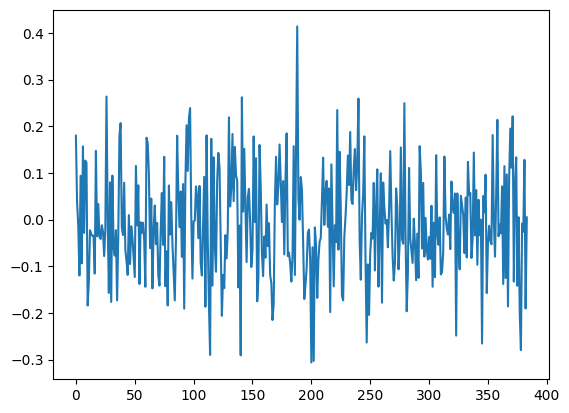

In [59]:
idx = 24
plt.plot(X_train[idx])
print(y_train[:10])
print(reg.predict(X_train[:10][:]))
print(X_train[:10].sum(axis=-1))